In [2]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


In [3]:
import numpy as np
import pandas as pd
import utm


In [14]:
veh_df = pd.read_parquet("/Users/max/Downloads/veh_df.prq")

summary_df = pd.read_csv("/Users/max/Downloads/summary_df.csv")


In [94]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

# use science plot
plt.style.use("science")


### Plot Trajectories

In [96]:
veh_df.loc[veh_df.ui32_objectID == 57522].dt.mean()

Timestamp('2022-05-23 17:43:30.720641792')

In [97]:
plot_df = veh_df.loc[
    (veh_df.dt > (veh_df.loc[veh_df.ui32_objectID == 57522].dt.mean() - pd.Timedelta(minutes=2))) & (veh_df.dt < (veh_df.loc[veh_df.ui32_objectID == 57522].dt.mean() + pd.Timedelta(minutes=2)))
]

In [117]:
plot_df = plot_df.loc[plot_df.groupby("ui32_objectID")['cum_distance'].transform('min') < 5]
plot_df = plot_df.loc[plot_df.groupby("ui32_objectID")['cum_distance'].transform('max') > 120]

# crop at cummulative distance of 140
plot_df = plot_df.loc[plot_df.cum_distance < 140]

Text(0, 0.5, 'Distance for Stop Bar [m]')

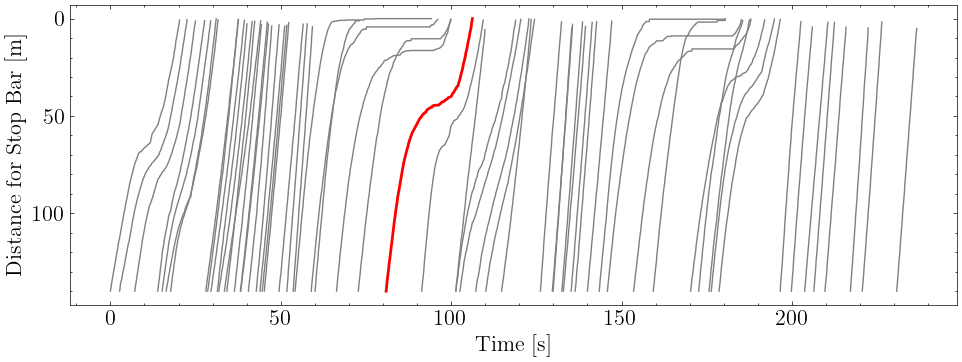

In [118]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
# make the font size 16
plt.rcParams.update({"font.size": 16})

start_time = plot_df.dt.min()


for veh, _veh_df in plot_df.groupby("ui32_objectID"):
    
    _veh_df.sort_values("dt", inplace=True)

    ax.plot(
        (_veh_df.dt - start_time).dt.total_seconds(),
        (140 - _veh_df.cum_distance),
        # color the line black
        color="red" if veh == 57479 else "gray",
        # make the line 1.5 points wide
        linewidth=2 if veh == 57479 else 1,
    )
# 

# reverse the y axis labels, not the data
ax.invert_yaxis()

# add axis labels
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance for Stop Bar [m]")

### Plot Some of the Results


/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_91511/2553487919.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, :2])


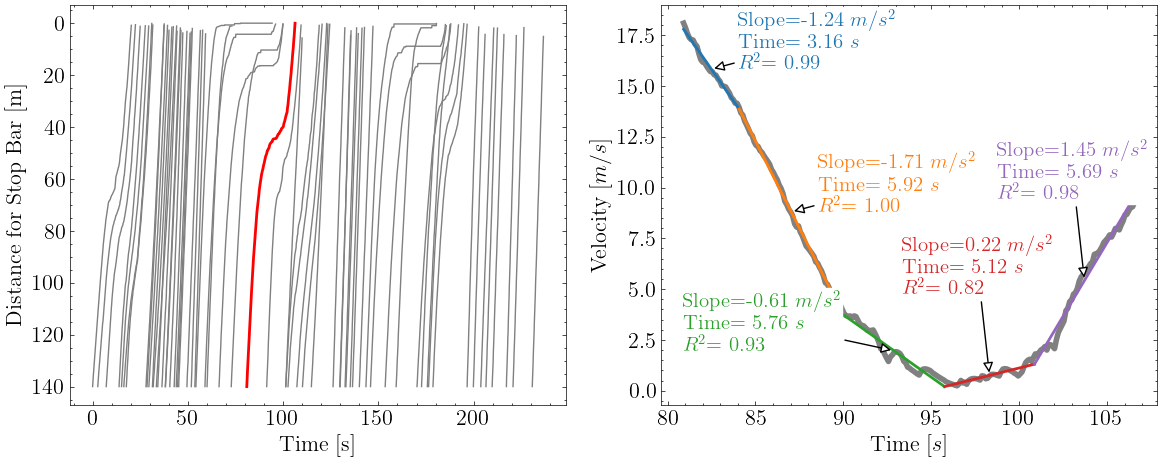

In [156]:
from matplotlib import gridspec


vehicle_ids = [ 57479]
# fig, axes = plt.subplots(figsize=(10, 4), ncols=1,  tight_layout=True)
# # make the font size 16
# plt.rcParams.update({"font.size": 16})

fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)
gs = gridspec.GridSpec(1, 4)

# make the font size 16
plt.rcParams.update({"font.size": 16})

start_time = plot_df.dt.min()

ax = plt.subplot(gs[0, :2])
for veh, _veh_df in plot_df.groupby("ui32_objectID"):
    
    _veh_df.sort_values("dt", inplace=True)

    ax.plot(
        (_veh_df.dt - start_time).dt.total_seconds(),
        (140 - _veh_df.cum_distance),
        # color the line black
        color="red" if veh == 57479 else "gray",
        # make the line 1.5 points wide
        linewidth=2 if veh == 57479 else 1,
    )
# 

# reverse the y axis labels, not the data
ax.invert_yaxis()

# add axis labels
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance for Stop Bar [m]")



ax = plt.subplot(gs[0, 2:])
for j, (vehicle_id, ax) in enumerate(zip(vehicle_ids,[ ax])):

    vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle_id]
    results = summary_df[summary_df["vehicle_id"] == vehicle_id].to_dict("records")

    offset_time = (vehicle_data["dt"].min() - start_time).total_seconds() 


    # for loop to plot the line fits using the class matplotlib.lines.Line2D(
    ax.plot(
            vehicle_data["relative_time"] + offset_time,
            vehicle_data["f32_velocityInDir_mps"],
            linewidth=4,
            color="grey",
        )

    colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]

    for i, line_fit in enumerate(results):
        break_ = line_fit["break"]
        slope = line_fit["slope"]
        r2 = line_fit["r2"]
        type_ = line_fit["type"]
        y0 = line_fit["y0"]
        min_time = line_fit["start"]
        max_time = line_fit["end"]
        n = len(ax.get_legend_handles_labels()[0]) + 1

        # with plt.style.context(["science", "muted"]):
        ax.plot(
            [min_time + offset_time, max_time + offset_time],
            [slope * (min_time) + y0, slope * (max_time) + y0],
            # add slope to the lable
            # label=f"Segment {n}: {slope:.2f} $m/s^2$, Time= {max_time - min_time:.2f} $s$, $R^2$= {r2:.2f}",
            # loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=8, markerscale=2, facecolor='white',
            linewidth=2,
            color=colors[break_],
            # markersize=10,
            # markeredgewidth=3,
        )

        orientation = "right" if (max_time + min_time) / 2 > ( vehicle_data["relative_time"].max() - 4) else "left"


        # add an annotation to the center of the line
        # if (j ==1) and (i == 2):
        #         ax.annotate(
        #         f" Slope={slope:.2f} $m/s^2$\n Time= {max_time - min_time:.2f} $s$\n $R^2$= {r2:.2f}",
        #         xy=((max_time + min_time) / 2, (slope * (max_time + min_time) / 2) + y0),
        #         xytext=((max_time + min_time) / 2 - 15, (slope * (max_time + min_time) / 2 ) + y0),
        #         fontsize=15,
        #         color=colors[break_],
        #         # center the text
        #         # horizontalalignment=orientation,
        #         # add a white background to the text
        #         bbox=dict(facecolor="white", edgecolor="white", pad=0.3, alpha=1),
        #         # arrowprops=dict(arrowstyle="->", connectionstyle="arc3")
        #         arrowprops=dict(arrowstyle="-|>",
        #                             connectionstyle="arc3,rad=0",
        #                             fc="w")
        #     )
        
        # else:
        ax.annotate(
            f" Slope={slope:.2f} $m/s^2$\n Time= {max_time - min_time:.2f} $s$\n $R^2$= {r2:.2f}",
            xy=((max_time + min_time) / 2 + offset_time, (slope * (max_time + min_time) / 2) + y0),
            xytext=((max_time + min_time) / 2 - (5 if slope > 0 else (-1.5 if i != 2 else 12)) + offset_time, (slope * (max_time + min_time) / 2 + (4 if slope > 0 else 0)) + y0),
            fontsize=15,
            color=colors[break_],
            # center the text
            # horizontalalignment=orientation,
            # add a white background to the text
            bbox=dict(facecolor="white", edgecolor="white", pad=0.3, alpha=1),
            # arrowprops=dict(arrowstyle="->", connectionstyle="arc3")
            arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=0",
                                fc="w")
        )

        # make background muted
        # ax.set_facecolor( 'white')

        # make background with no grid
        # ax.grid(False)
        

        # change size of the font for the x and y axis

    # add an annotation to the top right corner of the plot
    if j > 0:
        ax.annotate(
            f"Red Vehicle",
            xy=(0.95, 0.95),
            xytext=(0.95, 0.95),
            # make it relative to the image coordinates
            textcoords="axes fraction",

            fontsize=16,
            color="red",
            # # center the text
            horizontalalignment="right",
        )

    ax.set_xlabel("Time [$s$]")
    ax.set_ylabel("Velocity [$m/s$]")
    # ax.legend()

    # save the figure for best quality
# plt.savefig('C:/User folder/Downloads/vehicle_id_57522.png', dpi=300, bbox_inches='tight')


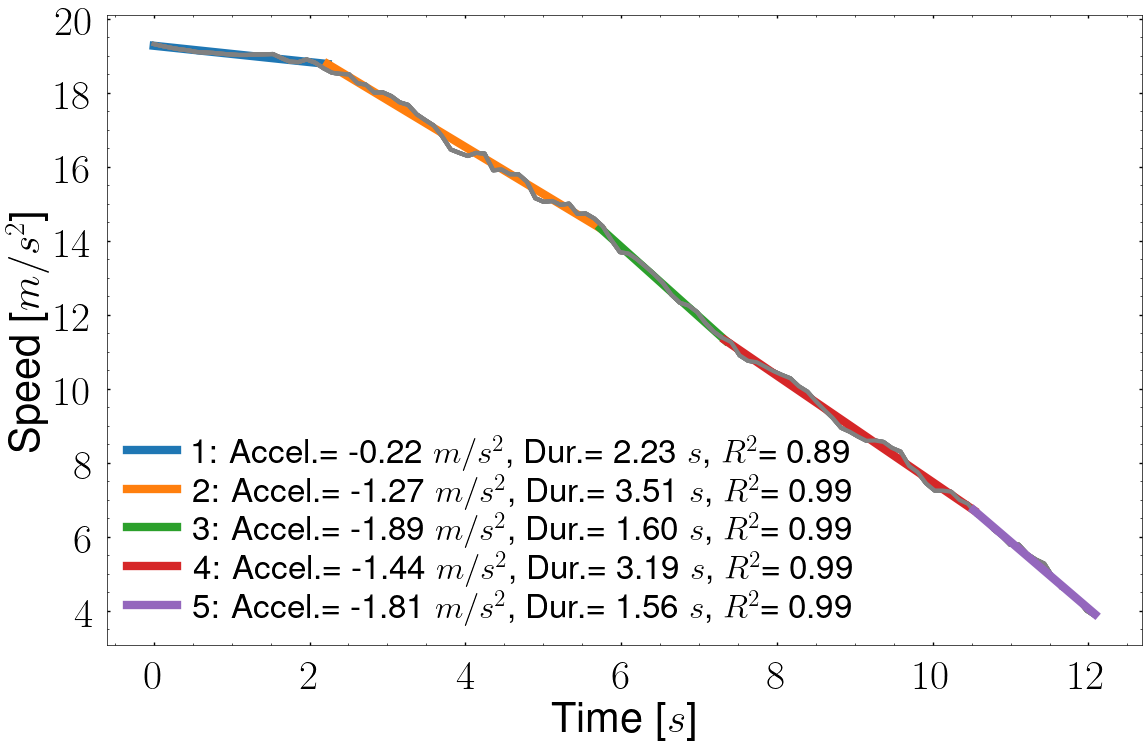

In [407]:
vehicle_id = 55912
axislabelfontsize = 30

vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle_id]
results = summary_df[summary_df["vehicle_id"] == vehicle_id].to_dict("records")

fig, ax = plt.subplots(figsize=(12, 8), sharey=False, tight_layout=True)
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "font.size": 21,
        "text.latex.preamble": [r"\usepackage{amsmath}"],
    }
)

# update the font size and darker font color
# plt.rcParams.update({"font.size": 60})


# create a color palette to to darken the color of the line
# palette = plt.get_cmap("Set1")


for line_fit in results:
    break_ = line_fit["break"]
    slope = line_fit["slope"]
    r2 = line_fit["r2"]
    type_ = line_fit["type"]
    y0 = line_fit["y0"]
    min_time = line_fit["start"]
    max_time = line_fit["end"]
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]
    n = len(ax.get_legend_handles_labels()[0]) + 1

    with plt.style.context(["science", "muted"]):
        ax.plot(
            vehicle_data["relative_time"],
            vehicle_data["f32_velocityInDir_mps"],
            linewidth=3,
            color="grey",
        )
        ax.plot(
            [min_time, max_time],
            [slope * (min_time) + y0, slope * (max_time) + y0],
            # add slope to the lable
            label=f"{n}: Accel.= {slope:.2f} $m/s^2$, Dur.= {max_time - min_time:.2f} $s$, $R^2$= {r2:.2f}",
            # loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=8, markerscale=2, facecolor='white',
            linewidth=6,
            color=colors[break_],
            markersize=10,
            markeredgewidth=3,
            # no grid
        )
    # make background muted
    # ax.set_facecolor( 'white')

    # make background with no grid
    # ax.grid(False)
    plt.grid(False)

    # change size of the font for the x and y axis
    plt.xlabel("Time [$s$]", fontsize=axislabelfontsize)
    plt.ylabel("Speed [$m/s^2$]", fontsize=axislabelfontsize)
    plt.xticks(fontsize=axislabelfontsize)
    plt.yticks(fontsize=axislabelfontsize)
    plt.tick_params(
        axis="both", direction="in", length=2, width=1, pad=10, top=True, right=True
    )
    # create different text type for the legend for example  italic, etc
    plt.legend(
        loc="lower left",
        ncol=1,
        shadow=True,
        fontsize=24,
        markerscale=10,
        facecolor="white",
        frameon=False,
        columnspacing=1.5,
        handletextpad=0.5,
        handlelength=1.5,
        labelspacing=0.1,
        borderpad=0.1,
        edgecolor="black",
    )
    # make text thicker

    plt.tight_layout()


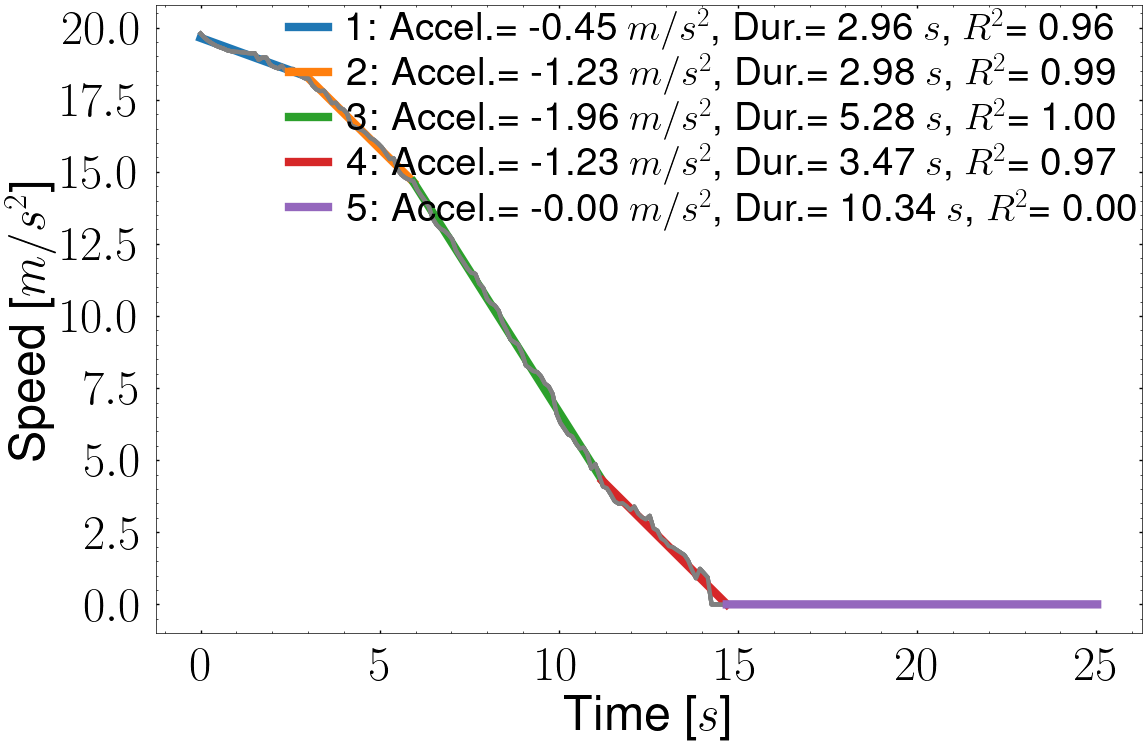

In [404]:
vehicle_id = 58441
axislabelfontsize = 35

vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle_id]
results = summary_df[summary_df["vehicle_id"] == vehicle_id].to_dict("records")

fig, ax = plt.subplots(figsize=(12, 8), sharey=False, tight_layout=True)
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "font.size": 21,
    }
)
# update the font size and darker font color
# plt.rcParams.update({"font.size": 60})


# create a color palette to to darken the color of the line
# palette = plt.get_cmap("Set1")


for line_fit in results:
    break_ = line_fit["break"]
    slope = line_fit["slope"]
    r2 = line_fit["r2"]
    type_ = line_fit["type"]
    y0 = line_fit["y0"]
    min_time = line_fit["start"]
    max_time = line_fit["end"]

    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]
    n = len(ax.get_legend_handles_labels()[0]) + 1

    with plt.style.context(["science", "muted"]):
        ax.plot(
            vehicle_data["relative_time"],
            vehicle_data["f32_velocityInDir_mps"],
            linewidth=3,
            color="grey",
        )
        ax.plot(
            [min_time, max_time],
            [slope * (min_time) + y0, slope * (max_time) + y0],
            # add slope to the lable
            label=f"{n}: Accel.= {slope:.2f} $m/s^2$, Dur.= {max_time - min_time:.2f} $s$, $R^2$= {r2:.2f}",
            # loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=8, markerscale=2, facecolor='white',
            linewidth=6,
            color=colors[break_],
            markersize=10,
            markeredgewidth=3,
            # no grid
        )
    # make background muted
    # ax.set_facecolor( 'white')

    # make background with no grid
    # ax.grid(False)
    plt.grid(False)

    # change size of the font for the x and y axis
    plt.xlabel("Time [$s$]", fontsize=axislabelfontsize)
    plt.ylabel("Speed [$m/s^2$]", fontsize=axislabelfontsize)
    # update the serif for the x and y axis "Helvetica"
    plt.xticks(fontsize=axislabelfontsize, fontname="Helvetica")
    plt.yticks(fontsize=axislabelfontsize, fontname="Helvetica")
    # make font name serif as lagend

    plt.tick_params(
        axis="both", direction="in", length=2, width=1, pad=10, top=True, right=True
    )
    # add no box to the legend
    # make text in the legend to add bigger markers
    # maj=ke text move away from the marker to the top
    plt.legend(
        loc="upper right",
        ncol=1,
        shadow=True,
        fontsize=28,
        markerscale=10,
        facecolor="white",
        frameon=False,
        columnspacing=0.1,
        handletextpad=0.5,
        handlelength=1.0,
        labelspacing=0.1,
        borderpad=0.1,
        edgecolor="black",
        bbox_to_anchor=(1.00, 1),
        borderaxespad=0,
    )
    # assign serif for thicker text
    # remove serifs

    plt.tight_layout()
    # save the figure for best quality
# plt.savefig('C:/User folder/Downloads/vehicle_id_57522.png', dpi=300, bbox_inches='tight')


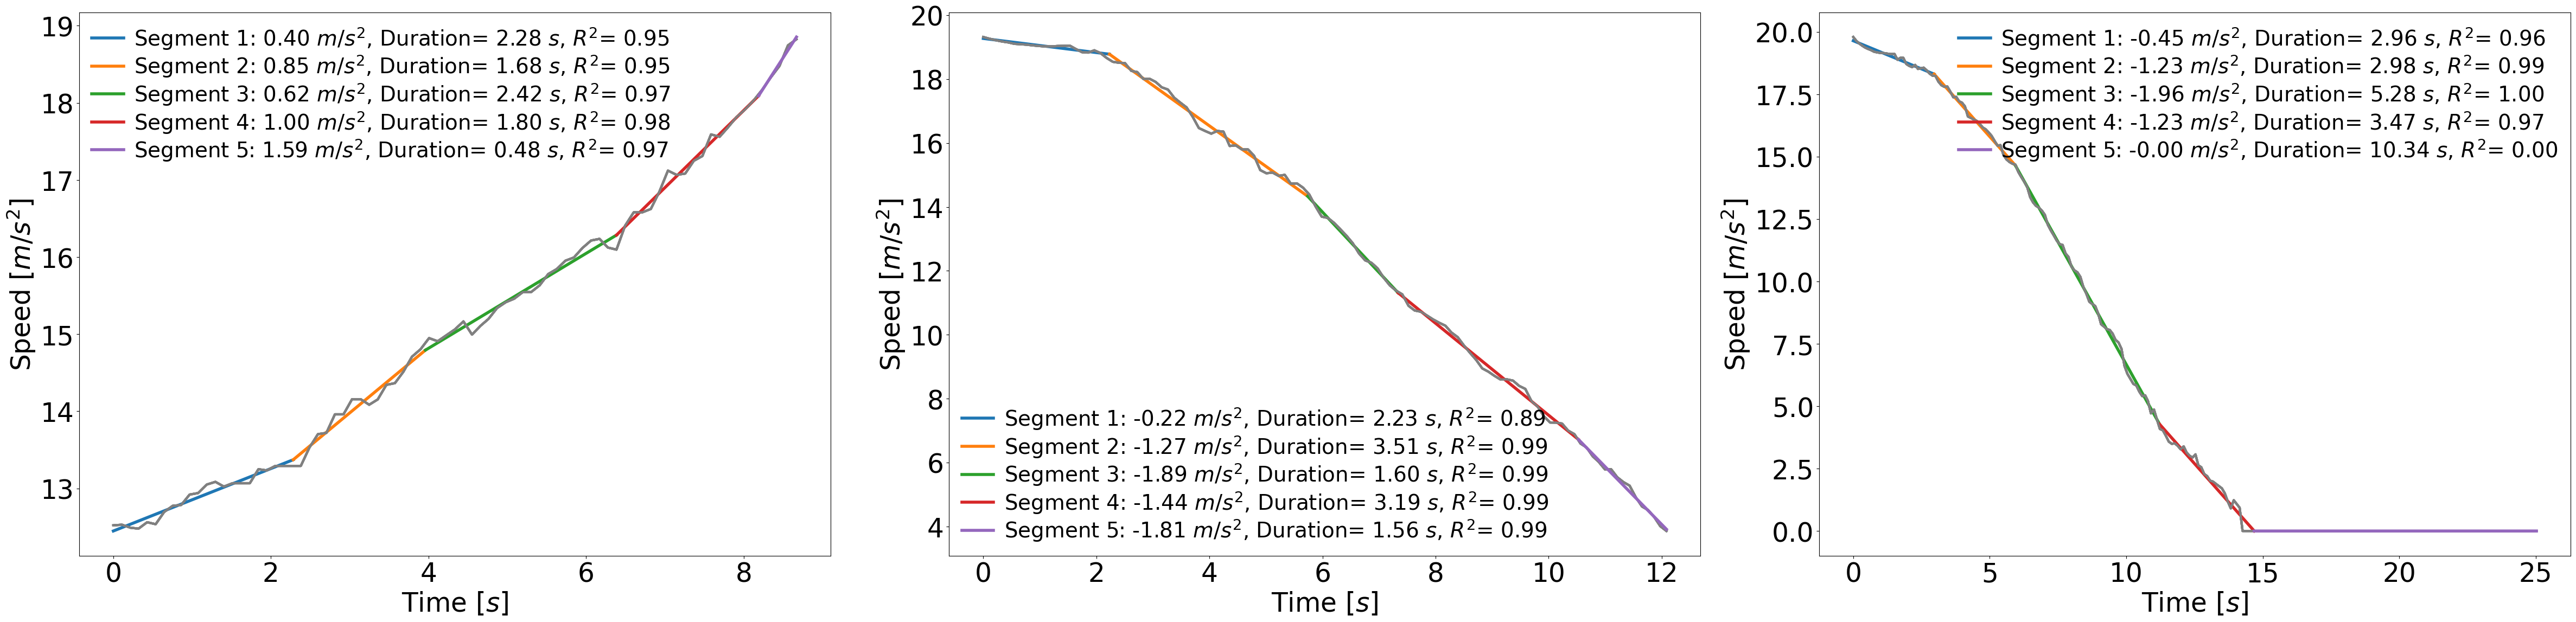

In [213]:
# compine the three vehicle ids together in one plot 1*3
# choose the vehicle three ids
vehicle_id = [57522, 55912, 58441]
vehicle_datas = [
    veh_df[veh_df["ui32_objectID"] == vehicle_id[0]],
    veh_df[veh_df["ui32_objectID"] == vehicle_id[1]],
    veh_df[veh_df["ui32_objectID"] == vehicle_id[2]],
]
results = [
    summary_df[summary_df["vehicle_id"] == vehicle_id[0]].to_dict("records"),
    summary_df[summary_df["vehicle_id"] == vehicle_id[1]].to_dict("records"),
    summary_df[summary_df["vehicle_id"] == vehicle_id[2]].to_dict("records"),
]
# set the size of the plot for three plots in one row for each plot is 12*8 update


fig, axs = plt.subplots(1, 3, figsize=(48, 12), sharey=False, tight_layout=True)

axislabelfontsize = 35

# make it work for three plots in one row
for i in range(3):
    # create a color palette to to darken the color of the line
    # palette = plt.get_cmap("Set1")

    # for loop to plot the line fits using the class matplotlib.lines.Line2D(

    for line_fit in results[i]:
        break_ = line_fit["break"]
        slope = line_fit["slope"]
        r2 = line_fit["r2"]
        type_ = line_fit["type"]
        y0 = line_fit["y0"]
        min_time = line_fit["start"]
        max_time = line_fit["end"]
        colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
        n = len(axs[i].get_legend_handles_labels()[0]) + 1

        with plt.style.context(["science"]):
            axs[i].plot(
                vehicle_datas[i]["relative_time"],
                vehicle_datas[i]["f32_velocityInDir_mps"],
                linewidth=3,
                color="grey",
            )
            axs[i].plot(
                [min_time, max_time],
                [slope * (min_time) + y0, slope * (max_time) + y0],
                # add slope to the lable
                label=f"Segment {n}: {slope:.2f} $m/s^2$, Duration= {max_time - min_time:.2f} $s$, $R^2$= {r2:.2f}",
                # loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=8, markerscale=2, facecolor='white',
                linewidth=4,
                color=colors[break_],
                markersize=10,
                markeredgewidth=2,
                # no grid
            )
        # make background muted
        # ax.set_facecolor( 'white')

        # make background with no grid
        # ax.grid(False)
        axs[i].grid(False)

        # change size of the font for the x and y axis
        axs[i].set_xlabel("Time [$s$]", fontsize=axislabelfontsize)
        axs[i].set_ylabel("Speed [$m/s^2$]", fontsize=axislabelfontsize)
        # make the x and y axis the same size
        axs[i].tick_params(axis="both", which="major", labelsize=axislabelfontsize)
        # change size for x and y

        # make legend seprtly for each plot
        # axs[i].legend( loc='upper right', ncol=1, shadow=True, fontsize=20, markerscale=4, facecolor='white', frameon=False, columnspacing=1.5, handletextpad=0.5, handlelength=1.5, labelspacing=0.1, borderpad=0.1)
        # change location of the legend for each plot differently for the first plot make it upper left , for the second plot make it lower left and for the third plot make it upper right
        if i == 0:
            axs[i].legend(
                loc="upper left",
                ncol=1,
                shadow=True,
                fontsize=28,
                markerscale=4,
                facecolor="white",
                frameon=False,
                columnspacing=1.5,
                handletextpad=0.5,
                handlelength=1.5,
                labelspacing=0.1,
                borderpad=0.1,
                prop={"size": 28},
            )
        elif i == 1:
            axs[i].legend(
                loc="lower left",
                ncol=1,
                shadow=True,
                fontsize=28,
                markerscale=4,
                facecolor="white",
                frameon=False,
                columnspacing=1.5,
                handletextpad=0.5,
                handlelength=1.5,
                labelspacing=0.1,
                borderpad=0.1,
            )
        else:
            axs[i].legend(
                loc="upper right",
                ncol=1,
                shadow=True,
                fontsize=28,
                markerscale=4,
                facecolor="white",
                frameon=False,
                columnspacing=1.5,
                handletextpad=0.5,
                handlelength=1.5,
                labelspacing=0.1,
                borderpad=0.1,
            )

        # make legend have high visibility


In [ ]:
# \begin{figure}
#     \centering
#     \includegraphics[width=0.32\textwidth]{acceleratetrj.png}
#     \includegraphics[width=0.32\textwidth]{decelratetrj.png}
#     \includegraphics[width=0.32\textwidth]{stopedtrj.png}
#     \caption{Clarifies the processed radar trajectories in distributions for three different vehicles.}
#     \label{fig:my_label}
# \end{figure}


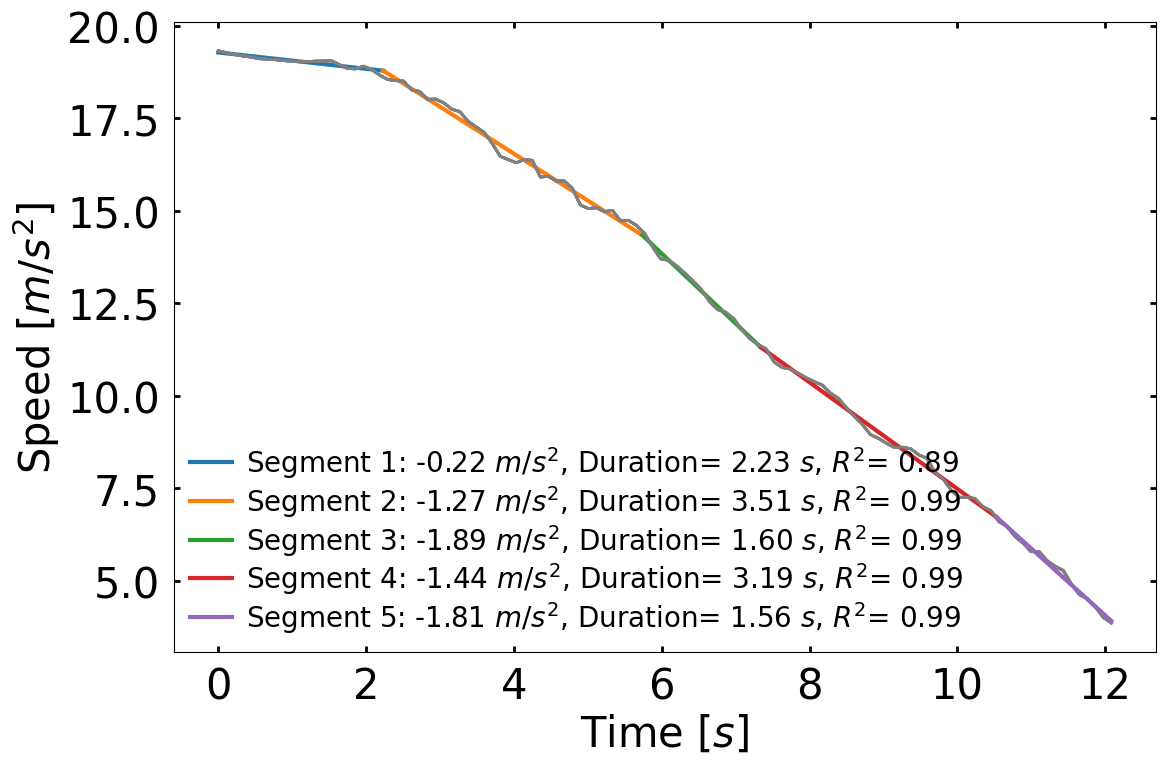

In [104]:
# use class to plot using matplotlib plt.style.use('science') for vehicle ID 55912
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots as sci
import matplotlib.font_manager as font_manager
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import rcParams as rc

axislabelfontsize = 30

vehicle_id = 55912

vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle_id]
results = summary_df[summary_df["vehicle_id"] == vehicle_id].to_dict("records")

fig, ax = plt.subplots(figsize=(12, 8), sharey=False, tight_layout=True)
# update the font size
# plt.rcParams.update({"font.size": 30})
# plt.rcParams.update({"font.size": 16})


# create a color palette
# palette = plt.get_cmap("Set1")
# rc = {'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
# for loop to plot the line fits using the class matplotlib.lines.Line2D(

for line_fit in results:
    break_ = line_fit["break"]
    slope = line_fit["slope"]
    r2 = line_fit["r2"]
    type_ = line_fit["type"]
    y0 = line_fit["y0"]
    min_time = line_fit["start"]
    max_time = line_fit["end"]
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]

    # make labels order by the number of labels in the legend
    n = len(ax.get_legend_handles_labels()[0]) + 1

    #    Segment {n}

    with plt.style.context(["science", "muted"]):
        ax.plot(
            vehicle_data["relative_time"],
            vehicle_data["f32_velocityInDir_mps"],
            linewidth=2,
            color="grey",
        )
        ax.plot(
            [min_time, max_time],
            [slope * (min_time) + y0, slope * (max_time) + y0],
            # add slope to the lable
            label=f"Segment {n}: {slope:.2f} $m/s^2$, Duration= {max_time - min_time:.2f} $s$, $R^2$= {r2:.2f}",
            # loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=8, markerscale=2, facecolor='white',
            linewidth=3,
            color=colors[break_],
            markersize=10,
            markeredgewidth=3,
            # no grid
        )
    # make background muted
    # ax.set_facecolor( 'white')

    # make background with no grid
    # ax.grid(False)
    ax.grid(False)
    # make text bigger for x and y axis
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=30,
        direction="in",
        length=4,
        width=2,
        pad=10,
        top=True,
        right=True,
    )
    # change type of text for s and m/s
    plt.xlabel("Time [$s$]", fontsize=axislabelfontsize)
    plt.ylabel("Speed [$m/s^2$]", fontsize=axislabelfontsize)
    # add no box to the legend
    # make fontsize thicker

    plt.legend(
        loc="lower left",
        ncol=1,
        shadow=True,
        fontsize=20,
        markerscale=4,
        facecolor="white",
        frameon=False,
        columnspacing=1.5,
        handletextpad=0.5,
        handlelength=1.5,
        labelspacing=0.1,
        borderpad=0.1,
    )


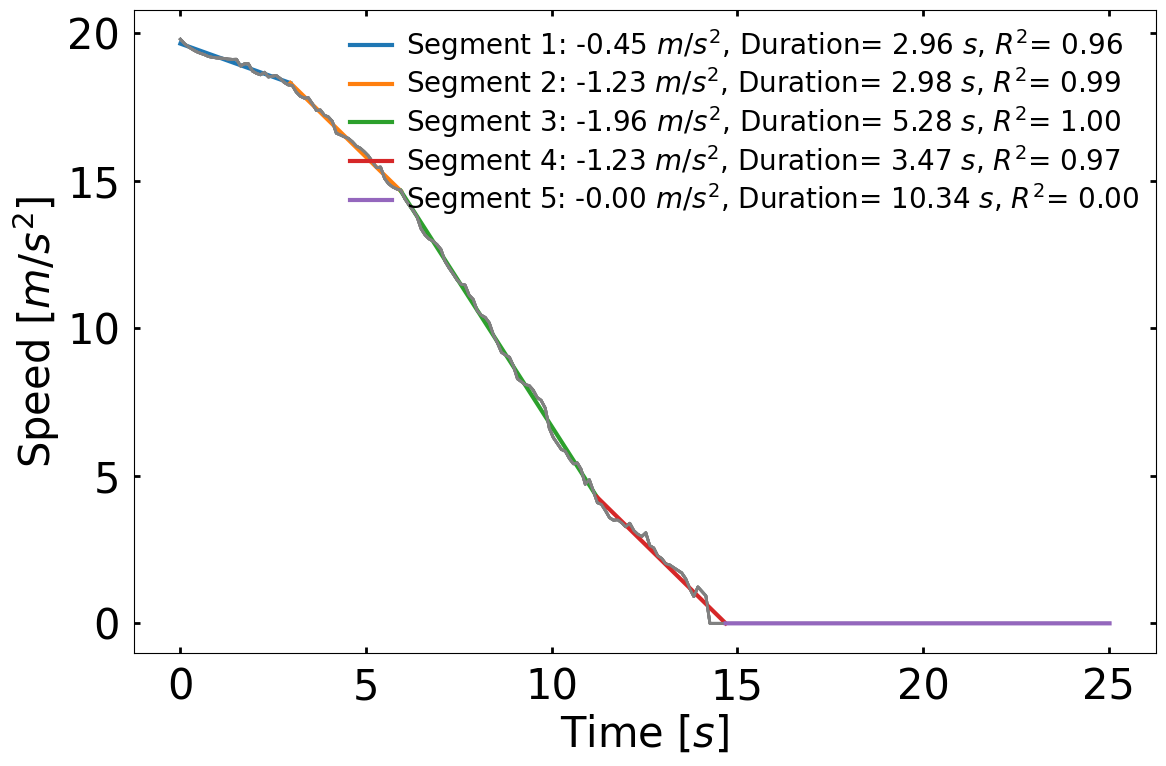

In [75]:
# use class to plot using matplotlib plt.style.use('science') for vehicle ID 55912
# import matplotlib.pyplot as plt
# import seaborn as sns
# import scienceplots as sci
# import matplotlib.font_manager as font_manager
# import matplotlib as mpl

# vehicle_id = 58441
# axislabelfontsize= 30

# vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle_id]
# results = summary_df[summary_df['vehicle_id'] == vehicle_id].to_dict('records')
# #make text bigger for x and y
# fig, ax = plt.subplots(figsize=(12, 8), sharey= False, tight_layout=True)
# # update the font size
# #plt.rcParams.update({"font.size": 30})
# #plt.rcParams.update({"font.size": 18})


# # create a color palette


# #for loop to plot the line fits using the class matplotlib.lines.Line2D(

# for line_fit in results:
#     break_ = line_fit["break"]
#     slope = line_fit["slope"]
#     r2 = line_fit["r2"]
#     type_ = line_fit["type"]
#     y0 = line_fit["y0"]
#     min_time = line_fit["start"]
#     max_time = line_fit["end"]
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#     n = len(ax.get_legend_handles_labels()[0]) + 1

#     with plt.style.context(['science','muted']):
#         #make size of text bigger
#         ax.plot(vehicle_data["relative_time"], vehicle_data["f32_velocityInDir_mps"], linewidth=2, color='grey')
#         ax.plot([min_time, max_time],
#         [slope * (min_time) + y0, slope * (max_time) + y0],
#         #add slope to the lable

#         label=f"Segment {n}: {slope:.2f} $m/s^2$, Duration= {max_time - min_time:.2f} $s$, $R^2$= {r2:.2f}",
#         #loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=8, markerscale=2, facecolor='white',
#         linewidth=3,
#         color=colors[break_],
#         markersize=10,
#         markeredgewidth=3,

#         #no grid

#         )
#     #make background muted
#     #ax.set_facecolor( 'white')

#     #make background with no grid
#     #ax.grid(False)
#     ax.grid(False)
#     #make text bigger for x and y and marker size bigger
#     ax.tick_params(axis='both', which='major', labelsize=30,  direction='in', length=4, width=2, pad=10, top=True, right=True)
#     #change size of the font for the x and y axis
#     plt.xlabel("Time [$s$]", fontsize=axislabelfontsize)
#     plt.ylabel("Speed [$m/s^2$]", fontsize=axislabelfontsize)
#     #add no box to the legend
#     # make line thicker
#     plt.legend( loc='upper right', ncol=1, shadow=True, fontsize=20, markerscale=4, facecolor='white', frameon=False, columnspacing=1.5, handletextpad=0.5, handlelength=1.5, labelspacing=0.1, borderpad=0.1)


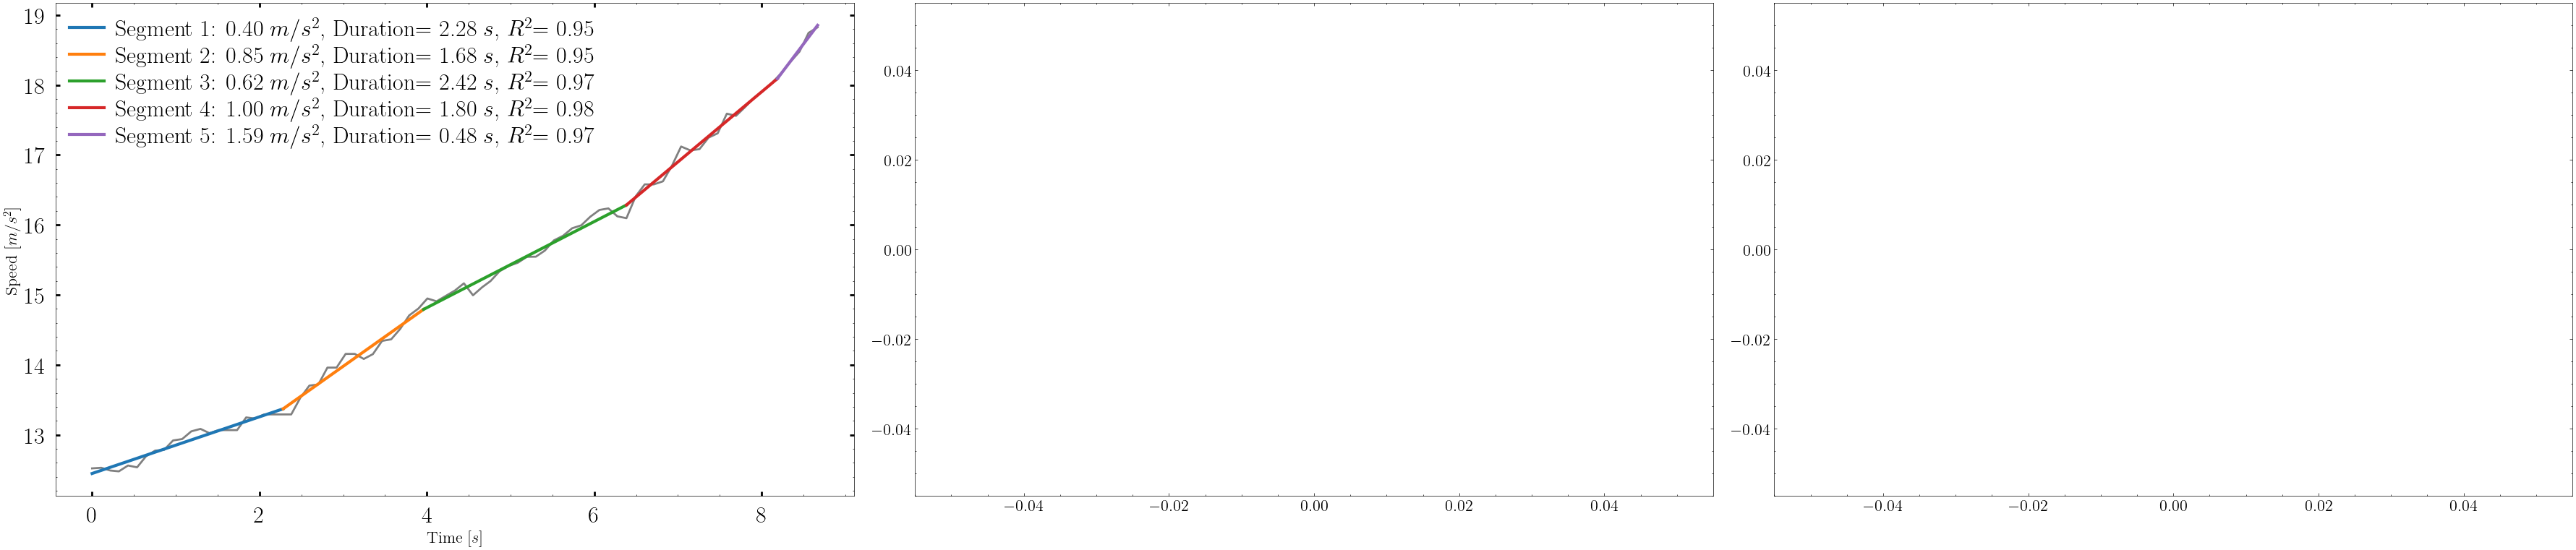

In [283]:
# assign vehicle_id to plot 3 vehicles in one plot
vehicle_id = [57522, 57523, 57524]
# assign fig for all three vehicles
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(36, 8), sharey=False, tight_layout=True
)
# create somthing to fit the three vehicles ax1, ax2, ax3
ax = [ax1, ax2, ax3]
for i, vehicle in enumerate(vehicle_id):
    vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle]
    results = summary_df[summary_df["vehicle_id"] == vehicle].to_dict("records")
    ax[i].plot(
        vehicle_data["relative_time"],
        vehicle_data["f32_velocityInDir_mps"],
        linewidth=2,
        color="grey",
    )
    for line_fit in results:
        break_ = line_fit["break"]
        slope = line_fit["slope"]
        r2 = line_fit["r2"]
        type_ = line_fit["type"]
        y0 = line_fit["y0"]
        min_time = line_fit["start"]
        max_time = line_fit["end"]
        colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
        n = len(ax[i].get_legend_handles_labels()[0]) + 1

        with plt.style.context(["science", "muted"]):
            ax[i].plot(
                [min_time, max_time],
                [slope * (min_time) + y0, slope * (max_time) + y0],
                # add slope to the lable
                label=f"Segment {n}: {slope:.2f} $m/s^2$, Duration= {max_time - min_time:.2f} $s$, $R^2$= {r2:.2f}",
                # loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=8, markerscale=2, facecolor='white',
                linewidth=3,
                color=colors[break_],
                markersize=4,
                # no grid
            )
        # make background muted
        # ax.set_facecolor( 'white')

        # make background with no grid
        # ax.grid(False)
        ax[i].grid(False)
        # make text bigger for x and y
        ax[i].tick_params(
            axis="both",
            which="major",
            labelsize=23,
            direction="in",
            length=4,
            width=2,
            pad=10,
            top=True,
            right=True,
        )
        # change size of the font for the x and y axis
        ax[i].set_xlabel("Time [$s$]", fontsize=axislabelfontsize)
        ax[i].set_ylabel("Speed [$m/s^2$]", fontsize=axislabelfontsize)
        # add no box to the legend

        ax[i].legend(
            loc="upper left",
            ncol=1,
            shadow=True,
            fontsize=23,
            markerscale=4,
            facecolor="white",
            frameon=False,
            columnspacing=1.5,
            handletextpad=0.5,
            handlelength=1.5,
            labelspacing=0.1,
            borderpad=0.1,
        )


In [ ]:
summary_df = pd.DataFrame([{**v, **l} for v in results for l in v.pop("line_fits")])


KeyError: 'line_fits'

In [ ]:
summary_df["minimum_time"] = summary_df["end"] - summary_df["start"]


In [133]:
summary_df


,vehicle_id,mean_time,total_seconds,break,y0,speed,slope,r2,rmse,start,end,type,minimum_time,average_speed,average_speed_cruise
0,55583,2022-05-23 17:15:55.730996224,20.017547,0,20.490881,19.864192,-0.522687,0.873620,0.143611,0.000000,2.426329,decel,2.426329,6.863265,NaN
1,55583,2022-05-23 17:15:55.730996224,20.017547,1,23.362297,11.487322,-1.706128,0.997292,0.231498,2.426329,11.532395,decel,9.106066,6.863265,NaN
2,55583,2022-05-23 17:15:55.730996224,20.017547,2,18.853235,1.894045,-1.315137,0.797753,0.537512,11.532395,14.347388,undefined,2.814993,6.863265,NaN
3,55583,2022-05-23 17:15:55.730996224,20.017547,3,-0.252386,0.008897,0.016508,0.178160,0.031112,14.347388,17.355502,cruise,3.008113,6.863265,0.008897
4,55583,2022-05-23 17:15:55.730996224,20.017547,4,-13.617157,1.061871,0.786568,0.932066,0.160892,17.355502,20.017547,accel,2.662045,6.863265,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,78161,2022-05-24 09:30:17.494800128,11.662750,0,15.653281,15.556953,-0.093587,0.228735,0.107360,0.000000,2.108903,cruise,2.108903,13.112471,15.556953
18975,78161,2022-05-24 09:30:17.494800128,11.662750,1,19.879020,14.982566,-2.097349,0.960130,0.048327,2.108903,2.609019,decel,0.500116,13.112471,NaN
18976,78161,2022-05-24 09:30:17.494800128,11.662750,2,12.929112,14.776991,0.566452,0.766748,0.129284,2.609019,3.980908,accel,1.371889,13.112471,NaN
18977,78161,2022-05-24 09:30:17.494800128,11.662750,3,19.471187,11.607119,-1.076911,0.988768,0.220554,3.980908,10.631989,decel,6.651081,13.112471,NaN


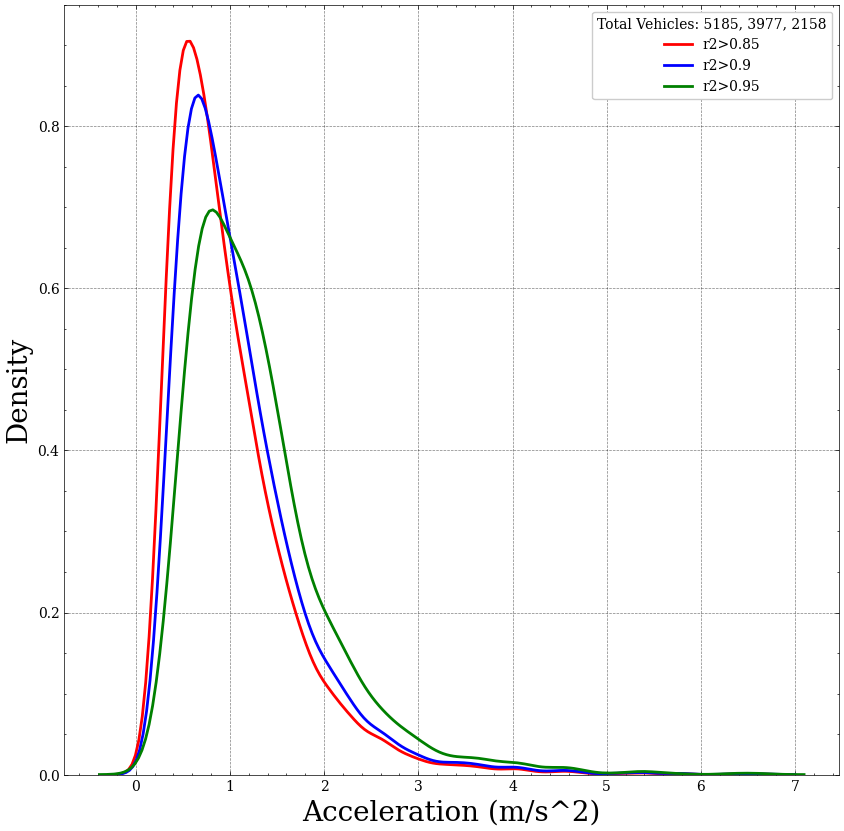

In [66]:
# importing the required libraries
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#using kde plot to plot the accel and r2>0.85, r2>0.9, r2>0.95 from the summary_df
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.kdeplot(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85), 'slope'], ax=axs, label='r2>0.85', color='red', linewidth=2)
sns.kdeplot(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .9), 'slope'], ax=axs, label='r2>0.9', color='blue', linewidth=2)
sns.kdeplot(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95), 'slope'], ax=axs, label='r2>0.95', color='green', linewidth=2)
axs.set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs.set_ylabel("Density", fontsize=20)
#show the total number of vehicles for all the r2>0.85, r2>0.9, r2>0.95 in the plot legend
axs.legend(title=f"Total Vehicles: {len(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85), 'slope'])}, {len(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .9), 'slope'])}, {len(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95), 'slope'])}")
plt.show()


























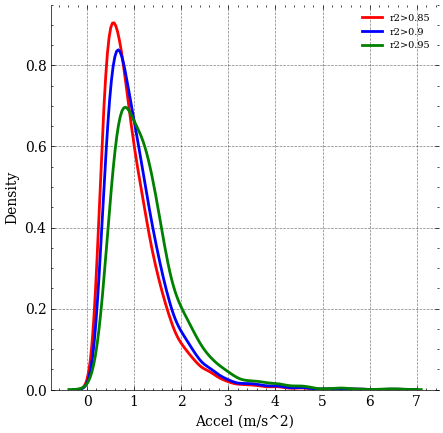

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

##using kde plot and matplotlib and seaborn to plot the accel and r2>0.85, r2>0.9, r2>0.95 from the summary_df use style science
with plt.style.context(
    ["science", "grid", "no-latex", "high-vis", "bright", "vibrant"]
):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.kdeplot(
        summary_df.loc[
            (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.85),
            "slope",
        ],
        ax=axs,
        label="r2>0.85",
        color="red",
        linewidth=2,
    )
    sns.kdeplot(
        summary_df.loc[
            (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.9),
            "slope",
        ],
        ax=axs,
        label="r2>0.9",
        color="blue",
        linewidth=2,
    )
    sns.kdeplot(
        summary_df.loc[
            (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.95),
            "slope",
        ],
        ax=axs,
        label="r2>0.95",
        color="green",
        linewidth=2,
    )
    style = dict(size=10, color="black", alpha=0.5)
    axs.set_xlabel("Accel (m/s^2)", fontsize=10)
    axs.set_ylabel("Density", fontsize=10)
    # show the total number of vehicles for all the r2>0.85, r2>0.9, r2>0.95 in the plot legend
    axs.legend(
        title=f"Total Vehicles: {len(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85), 'slope'])}, {len(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .9), 'slope'])}, {len(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95), 'slope'])}"
    )
    axs.legend(
        frameon=False,
        facecolor="white",
        edgecolor="black",
        framealpha=1,
        loc="upper right",
        fontsize=7,
    )
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)

    plt.show()


In [ ]:
# what does r2>0.85, r2>0.9, r2>0.95 mean?
# r2 is the coefficient of determination, which is a measure of how well the data fits the regression line.
# r2>0.85 means that the data fits the regression line well, and r2>0.9 means that the data fits the regression line very well.
# r2>0.95 means that the data fits the regression line perfectly.
# r2 is a measure of how well the data fits the regression line, and the higher the r2, the better the data fits the regression line and the more accurate the regression line is
# what is our result for r2>0.85, r2>0.9, r2>0.95 mean
# what is the releshionship between r2 and acceleration?
# the higher the r2, the higher the acceleration.
# what is the releshionship between r2 and speed?
# the higher the r2, the higher the speed.
# what is the releshionship between r2 and slope?
# classifying the r2 results into 3 groups: r2>0.85, r2>0.9, r2>0.95 with acceleration isimportant to understand the relationship between r2 and acceleration.
# classifying the r2 results into 3 groups: r2>0.85, r2>0.9, r2>0.95 with speed is important to understand the relationship between r2 and speed.
# acceleration and r2>0.85, r2>0.9, r2>0.95 were plotted in the same plot to understand the relationship between r2 and acceleration


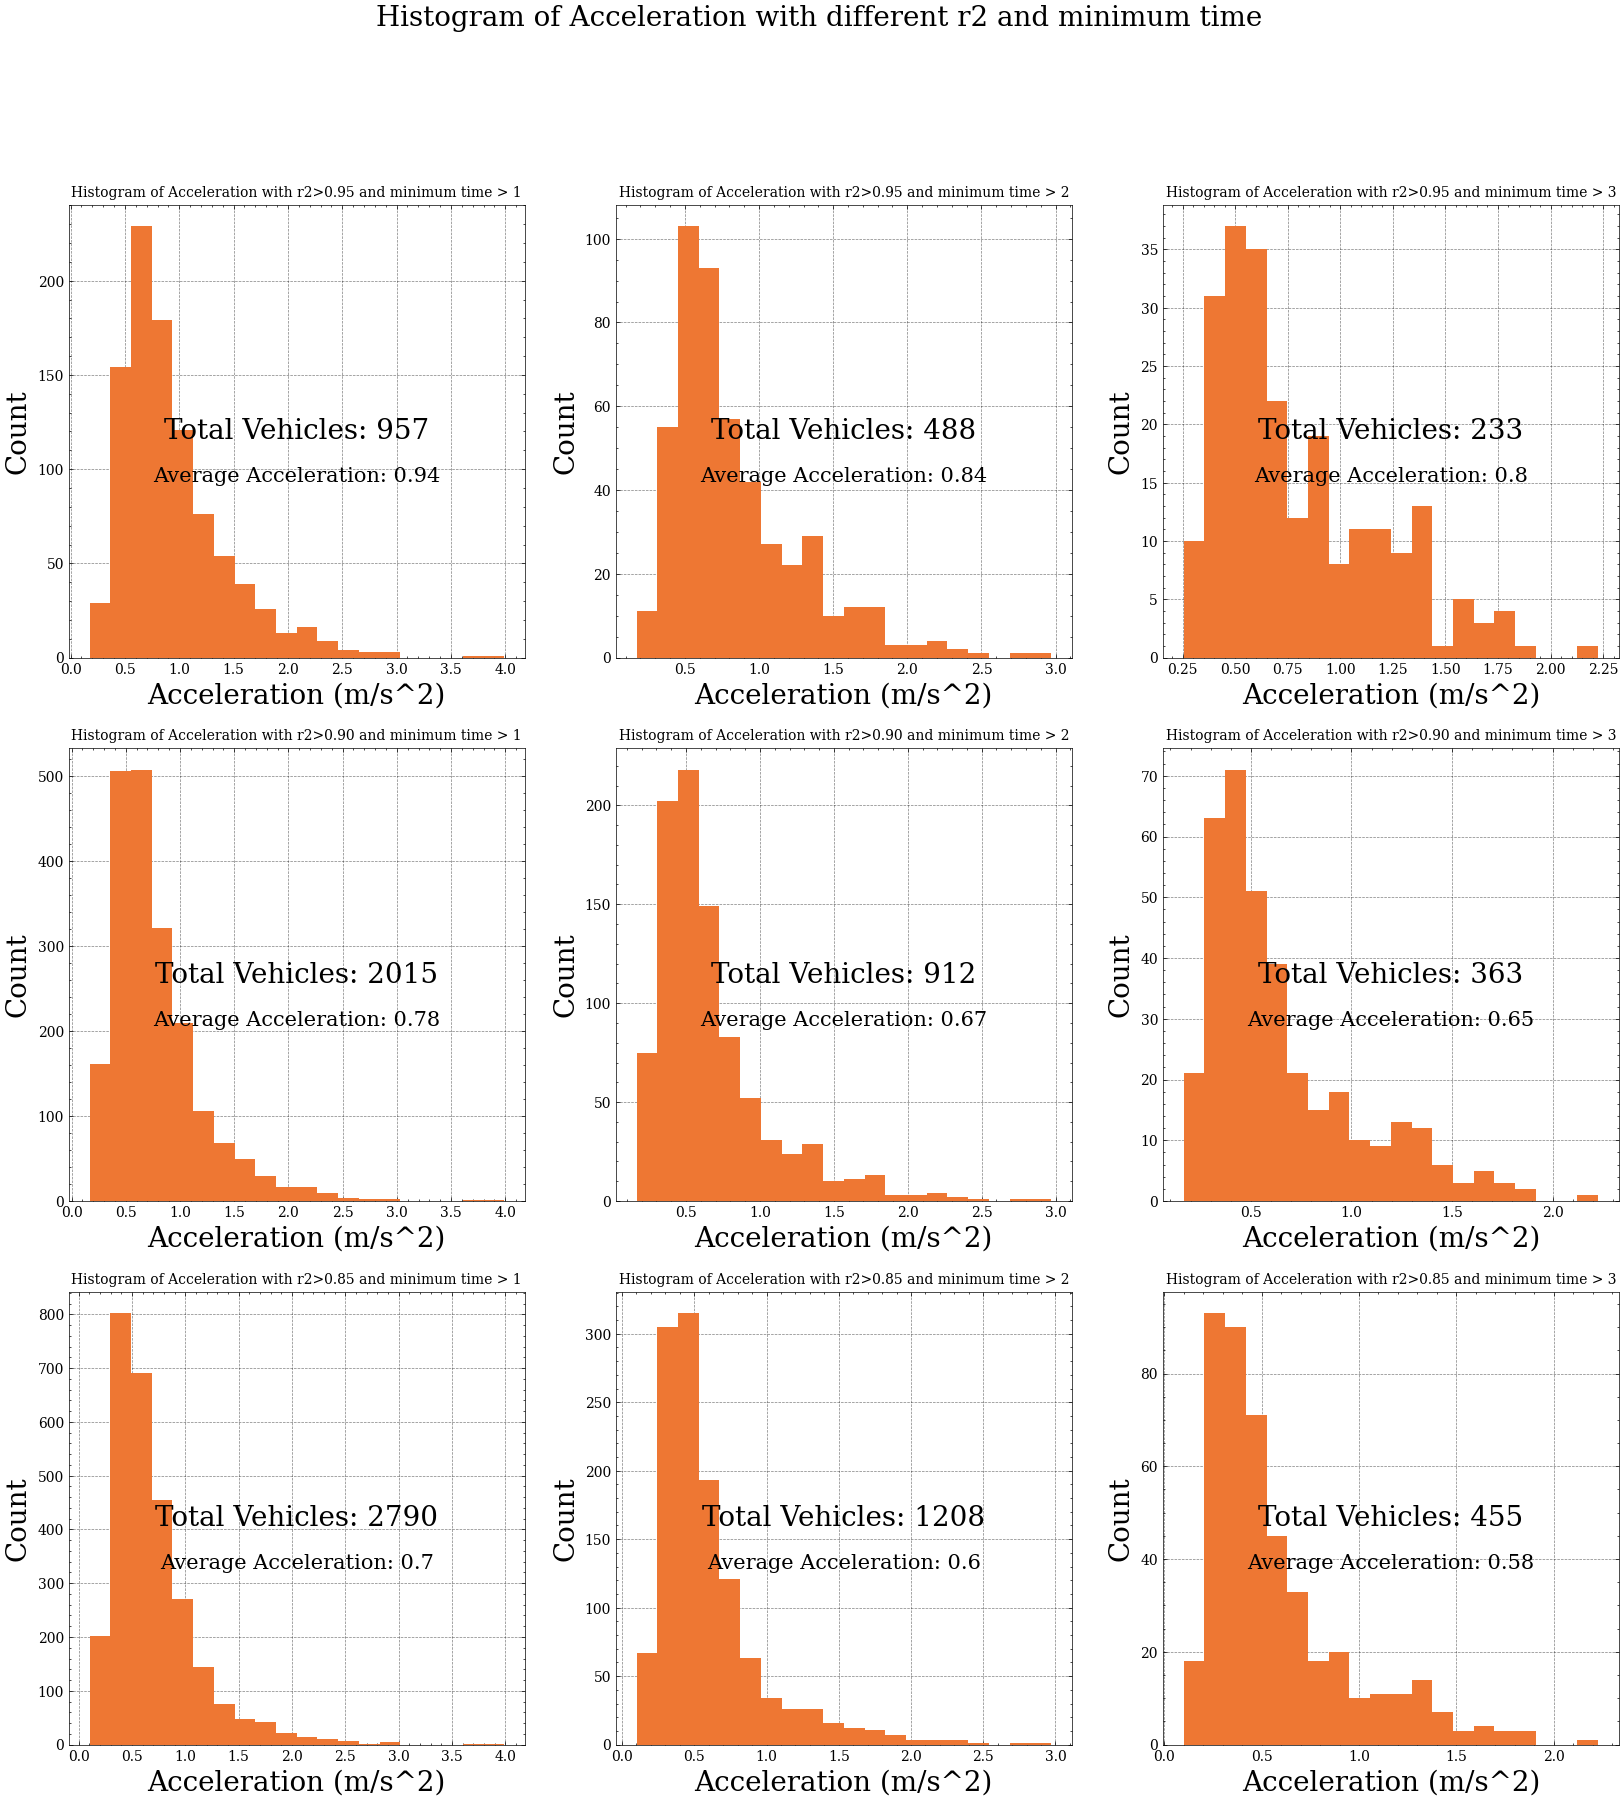

In [ ]:
# make histogram of acceleration 3*3 histogram of acceleration with different r2 and minimum time
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle(
    "Histogram of Acceleration with different r2 and minimum time", fontsize=20
)
# r2>0.95 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[0, 0])
axs[0, 0].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 1", fontsize=10
)
axs[0, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 0].set_ylabel("Count", fontsize=20)
axs[0, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=20,
)
# axs[0,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[0,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[0, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=15,
)

# r2>0.95 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 2", fontsize=10
)
axs[0, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 1].set_ylabel("Count", fontsize=20)
axs[0, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=20,
)
# write average acceleration on the graph with accuracy of actual value
axs[0, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=15,
)
# r2>0.95 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[0, 2])
axs[0, 2].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 3", fontsize=10
)
axs[0, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 2].set_ylabel("Count", fontsize=20)
axs[0, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=20,
)
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[0,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[0, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=15,
)
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[0,2].legend()
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[0,2].legend()
# r2>0.90 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 1", fontsize=10
)
axs[1, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 0].set_ylabel("Count", fontsize=20)
axs[1, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=20,
)
# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=15,
)

# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,0].legend()
# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,0].legend()
# r2>0.90 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 2", fontsize=10
)
axs[1, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 1].set_ylabel("Count", fontsize=20)
axs[1, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=20,
)
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,1].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=15,
)
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,1].legend()
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,1].legend()
# r2>0.90 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[1, 2])
axs[1, 2].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 3", fontsize=10
)
axs[1, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 2].set_ylabel("Count", fontsize=20)
axs[1, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=20,
)
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=15,
)
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,2].legend()
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,2].legend()
# r2>0.85 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 1", fontsize=10
)
axs[2, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)
# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=15,
)

# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,0].legend()
# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,0].legend()
# r2>0.85 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 2", fontsize=10
)
axs[2, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 1].set_ylabel("Count", fontsize=20)
axs[2, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=20,
)
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,1].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=15,
)
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,1].legend()
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,1].legend()
# r2>0.85 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[2, 2])
axs[2, 2].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 3", fontsize=10
)
axs[2, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 2].set_ylabel("Count", fontsize=20)
axs[2, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=20,
)
# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=15,
)

# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,2].legend()
# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,2].legend()
plt.show()


In [ ]:
# plot of acceleration with r2>0.85 ,r2>0.9 and r2>0.95 in one graph with label= linear
# r2>0.85

summary_df.loc[
    (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.85), "slope"
].hist(bins=20, ax=axs[2, 0], label="r2>0.85")
axs[2, 0].set_title("Histogram of Acceleration with r2>0.85", fontsize=10)
axs[2, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.85),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)


NameError: name 'axs' is not defined

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


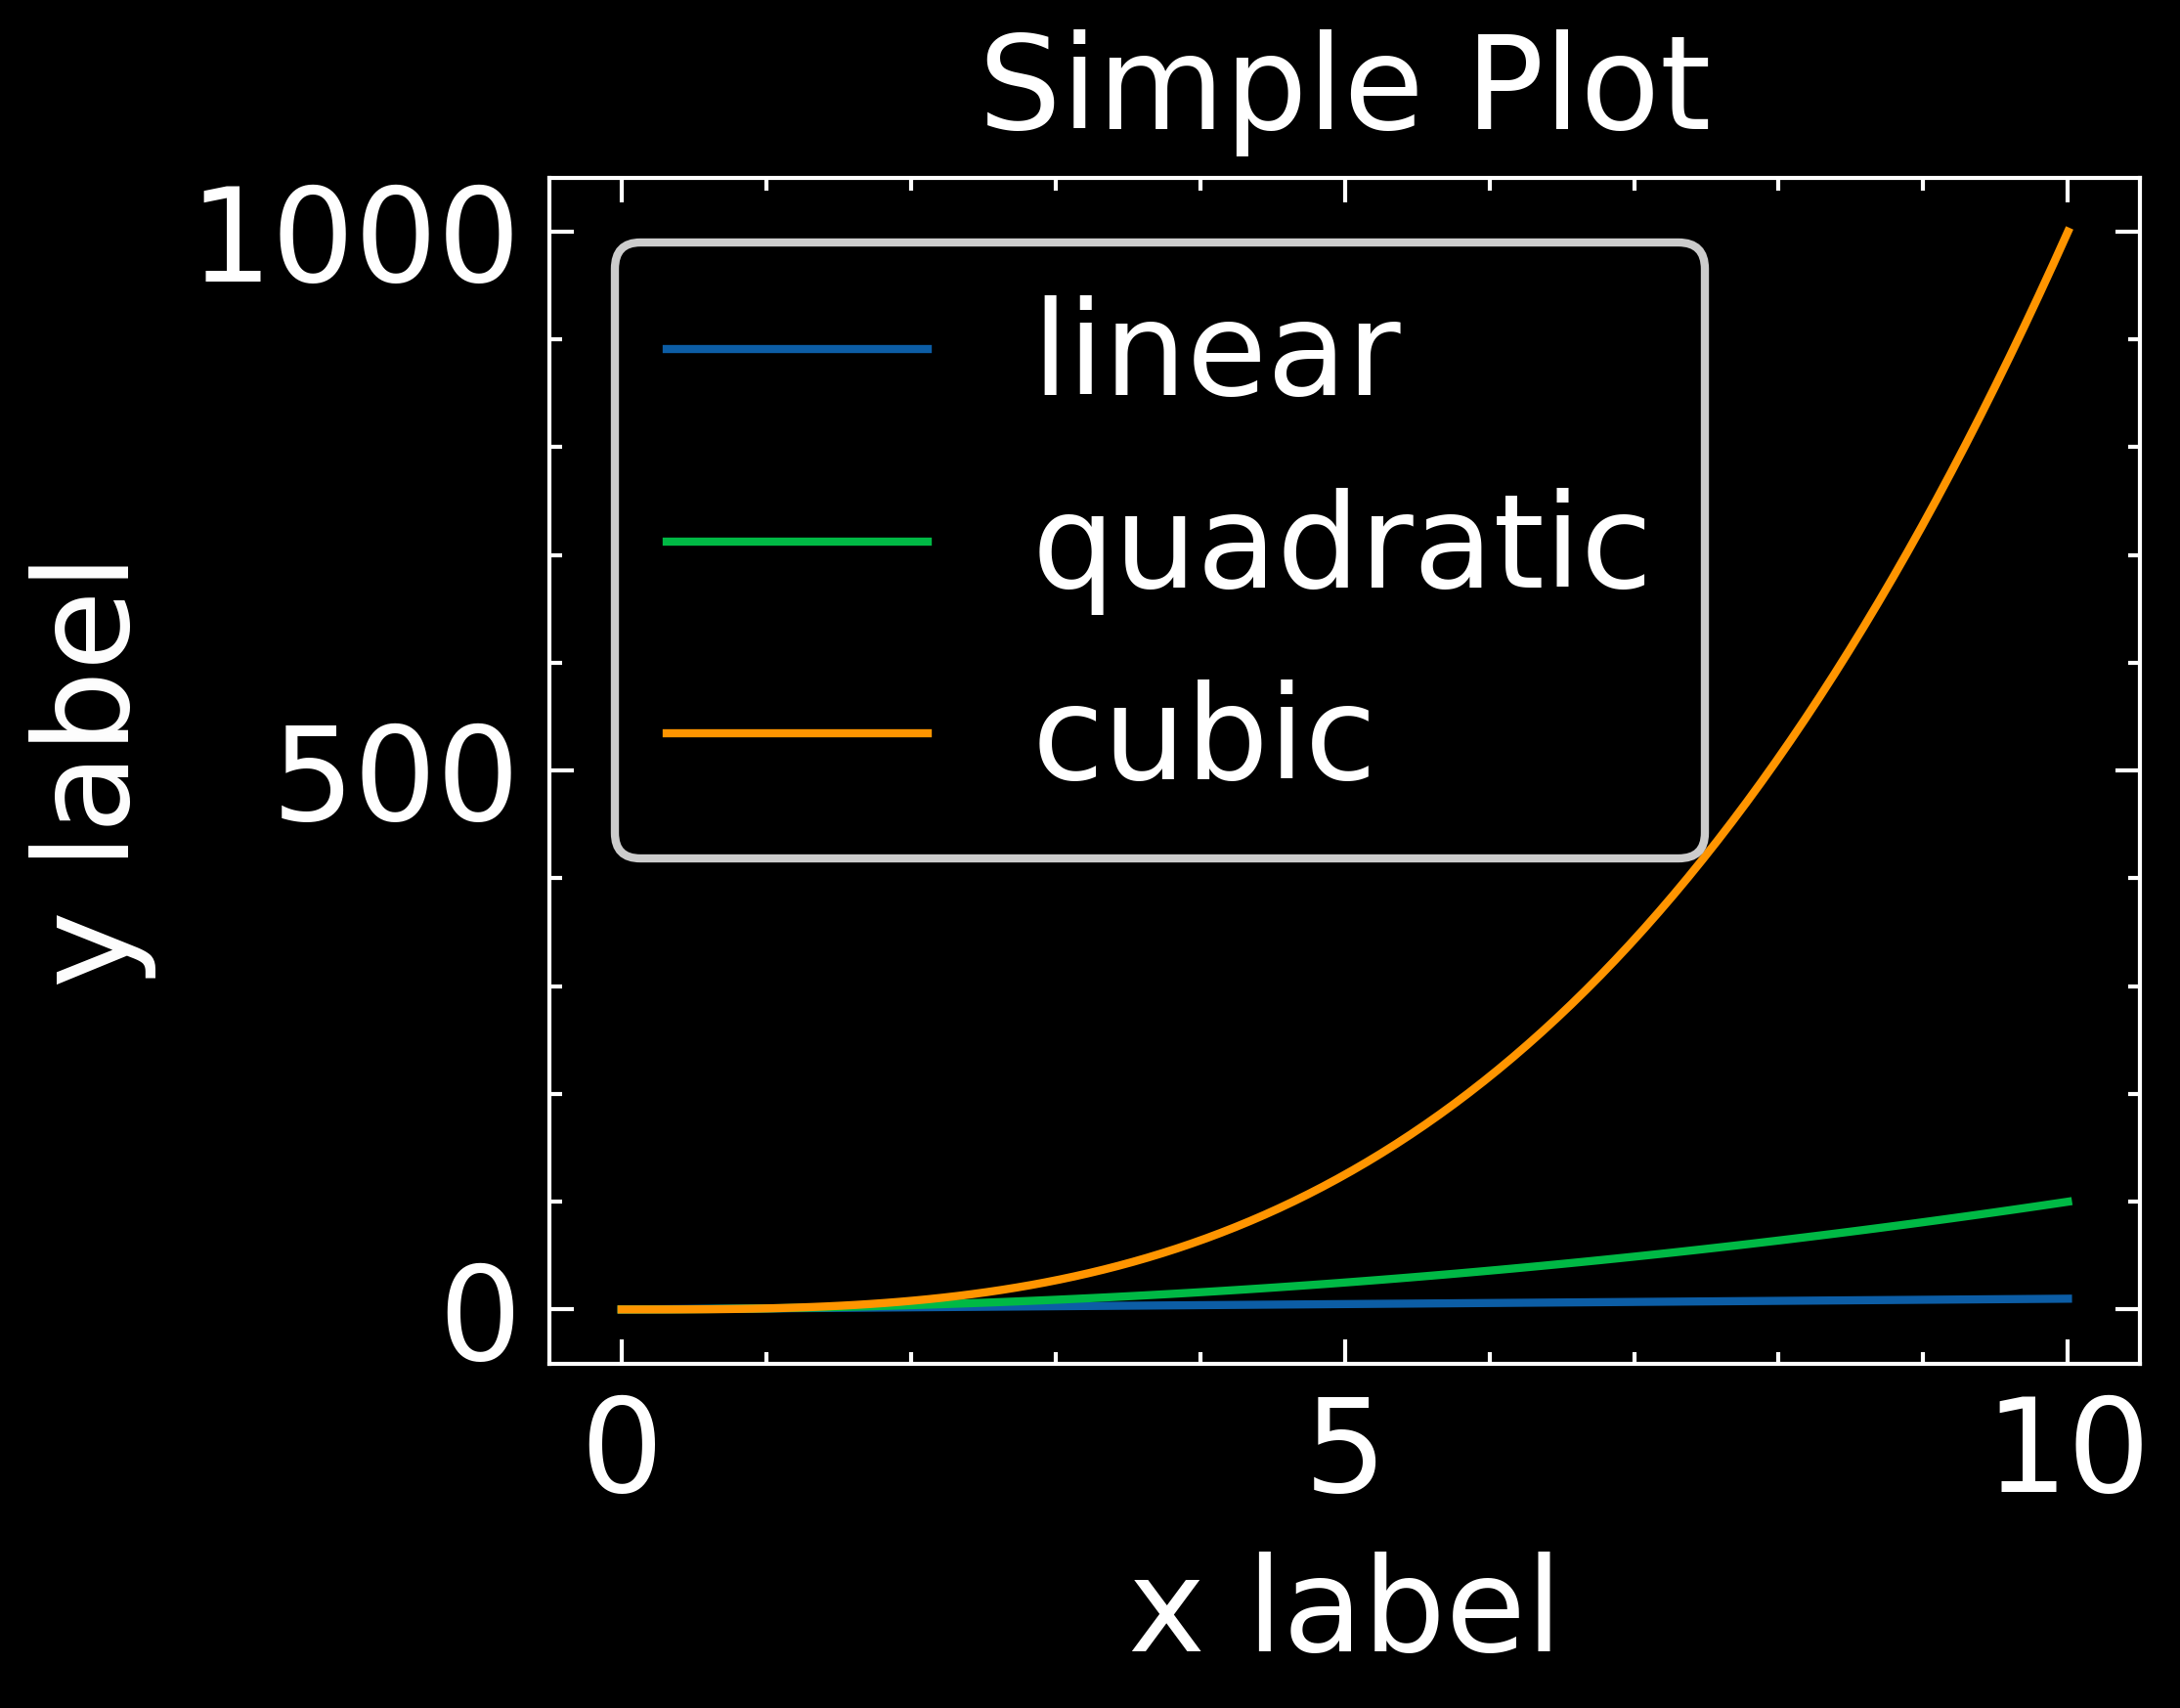

In [ ]:
# in one graph plot acceleration with r2>0.85, r2>0.9, r2>0.95, r2>0.99  plot as lines for r2>0.85, r2>0.9, r2>0.95, r2>0.99
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
fig, ax = plt.subplots()
ax.plot(x, x, label="linear")
ax.plot(x, x**2, label="quadratic")
ax.plot(x, x**3, label="cubic")
ax.set_xlabel("x label")
ax.set_ylabel("y label")
ax.set_title("Simple Plot")
ax.legend()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

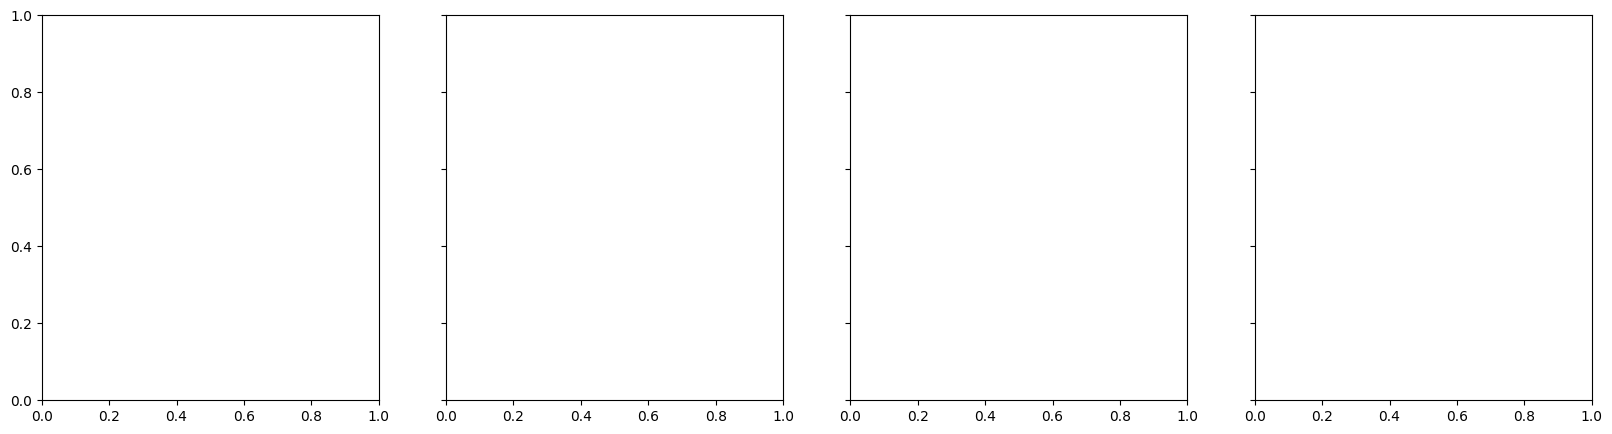

In [ ]:
# use simple plot above to plot accel with r2>0.85, r2>0.9, r2>0.95, r2>0.99  plot as lines for r2>0.85, r2>0.9, r2>0.95, r2>0.99
import matplotlib.pyplot as plt
import numpy as np

# use different libraries for plotting
# import different libraries for plotting
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# make it 1*4 graph
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# plot of acceleration with r2>0.85 ,r2>0.9 and r2>0.95 using lines to represent r2>0.85, r2>0.9 and r2>0.95
# r2>0.85


# fig, ax = plt.subplots()


# ax.plot(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85), 'slope'], label='r2>0.85')
# ax.plot(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .9), 'slope'], label='r2>0.9')
# ax.plot(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95), 'slope'], label='r2>0.95')
# ax.plot(summary_df.loc[ (summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .99), 'slope'], label='r2>0.99')
# ax.set_xlabel('x label')
# ax.set_ylabel('y label')
# ax.set_title("Simple Plot")
# ax.legend()


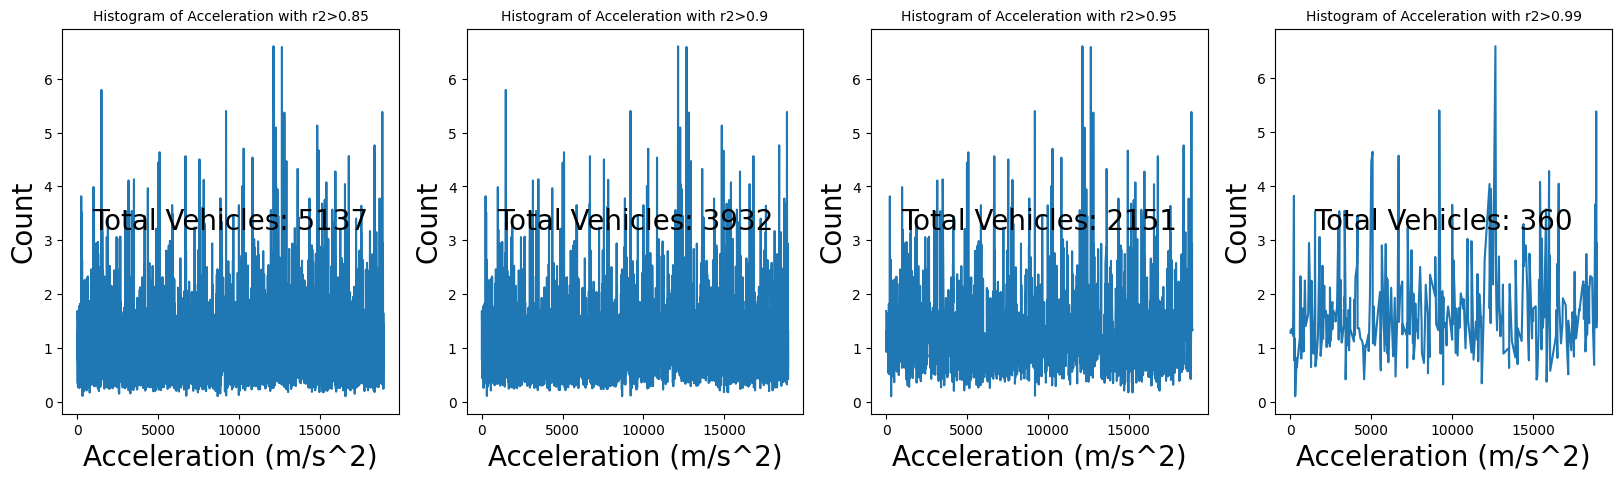

In [ ]:
# use simple plot above to plot accel with r2>0.85, r2>0.9, r2>0.95, r2>0.99  plot as lines for r2>0.85, r2>0.9, r2>0.95, r2>0.99, add average
# 1 * 4 graph
import matplotlib.pyplot as plt

# make it 1*4 plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(
    summary_df.loc[
        (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.85), "slope"
    ],
    label="r2>0.85",
)
ax[0].set_title("Histogram of Acceleration with r2>0.85", fontsize=10)
ax[0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
ax[0].set_ylabel("Count", fontsize=20)
ax[0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.85),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
    fontsize=20,
)

ax[1].plot(
    summary_df.loc[
        (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.9), "slope"
    ],
    label="r2>0.9",
)
ax[1].set_title("Histogram of Acceleration with r2>0.9", fontsize=10)
ax[1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
ax[1].set_ylabel("Count", fontsize=20)
ax[1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.9),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
    fontsize=20,
)

ax[2].plot(
    summary_df.loc[
        (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.95), "slope"
    ],
    label="r2>0.95",
)
ax[2].set_title("Histogram of Acceleration with r2>0.95", fontsize=10)
ax[2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
ax[2].set_ylabel("Count", fontsize=20)
ax[2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.95),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[2].transAxes,
    fontsize=20,
)

ax[3].plot(
    summary_df.loc[
        (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.99), "slope"
    ],
    label="r2>0.99",
)
ax[3].set_title("Histogram of Acceleration with r2>0.99", fontsize=10)
ax[3].set_xlabel("Acceleration (m/s^2)", fontsize=20)
ax[3].set_ylabel("Count", fontsize=20)
# make total vehicles as text in the plot in the top left corner of the plot

ax[3].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.99),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[3].transAxes,
    fontsize=20,
)

plt.show()


In [ ]:
# use simple plot above to plot accel m/s^2 with r2>0.85, r2>0.9, r2>0.95, r2>0.99  plot as lines for r2>0.85, r2>0.9, r2>0.95, r2>0.99
# 1 * 4 graph
import matplotlib.pyplot as plt

# make it 1*4 plot
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].plot(
    summary_df.loc[
        (summary_df["type"].str.contains("accel")) & (summary_df["r2"] > 0.85), "slope"
    ],
    label="r2>0.85",
)


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


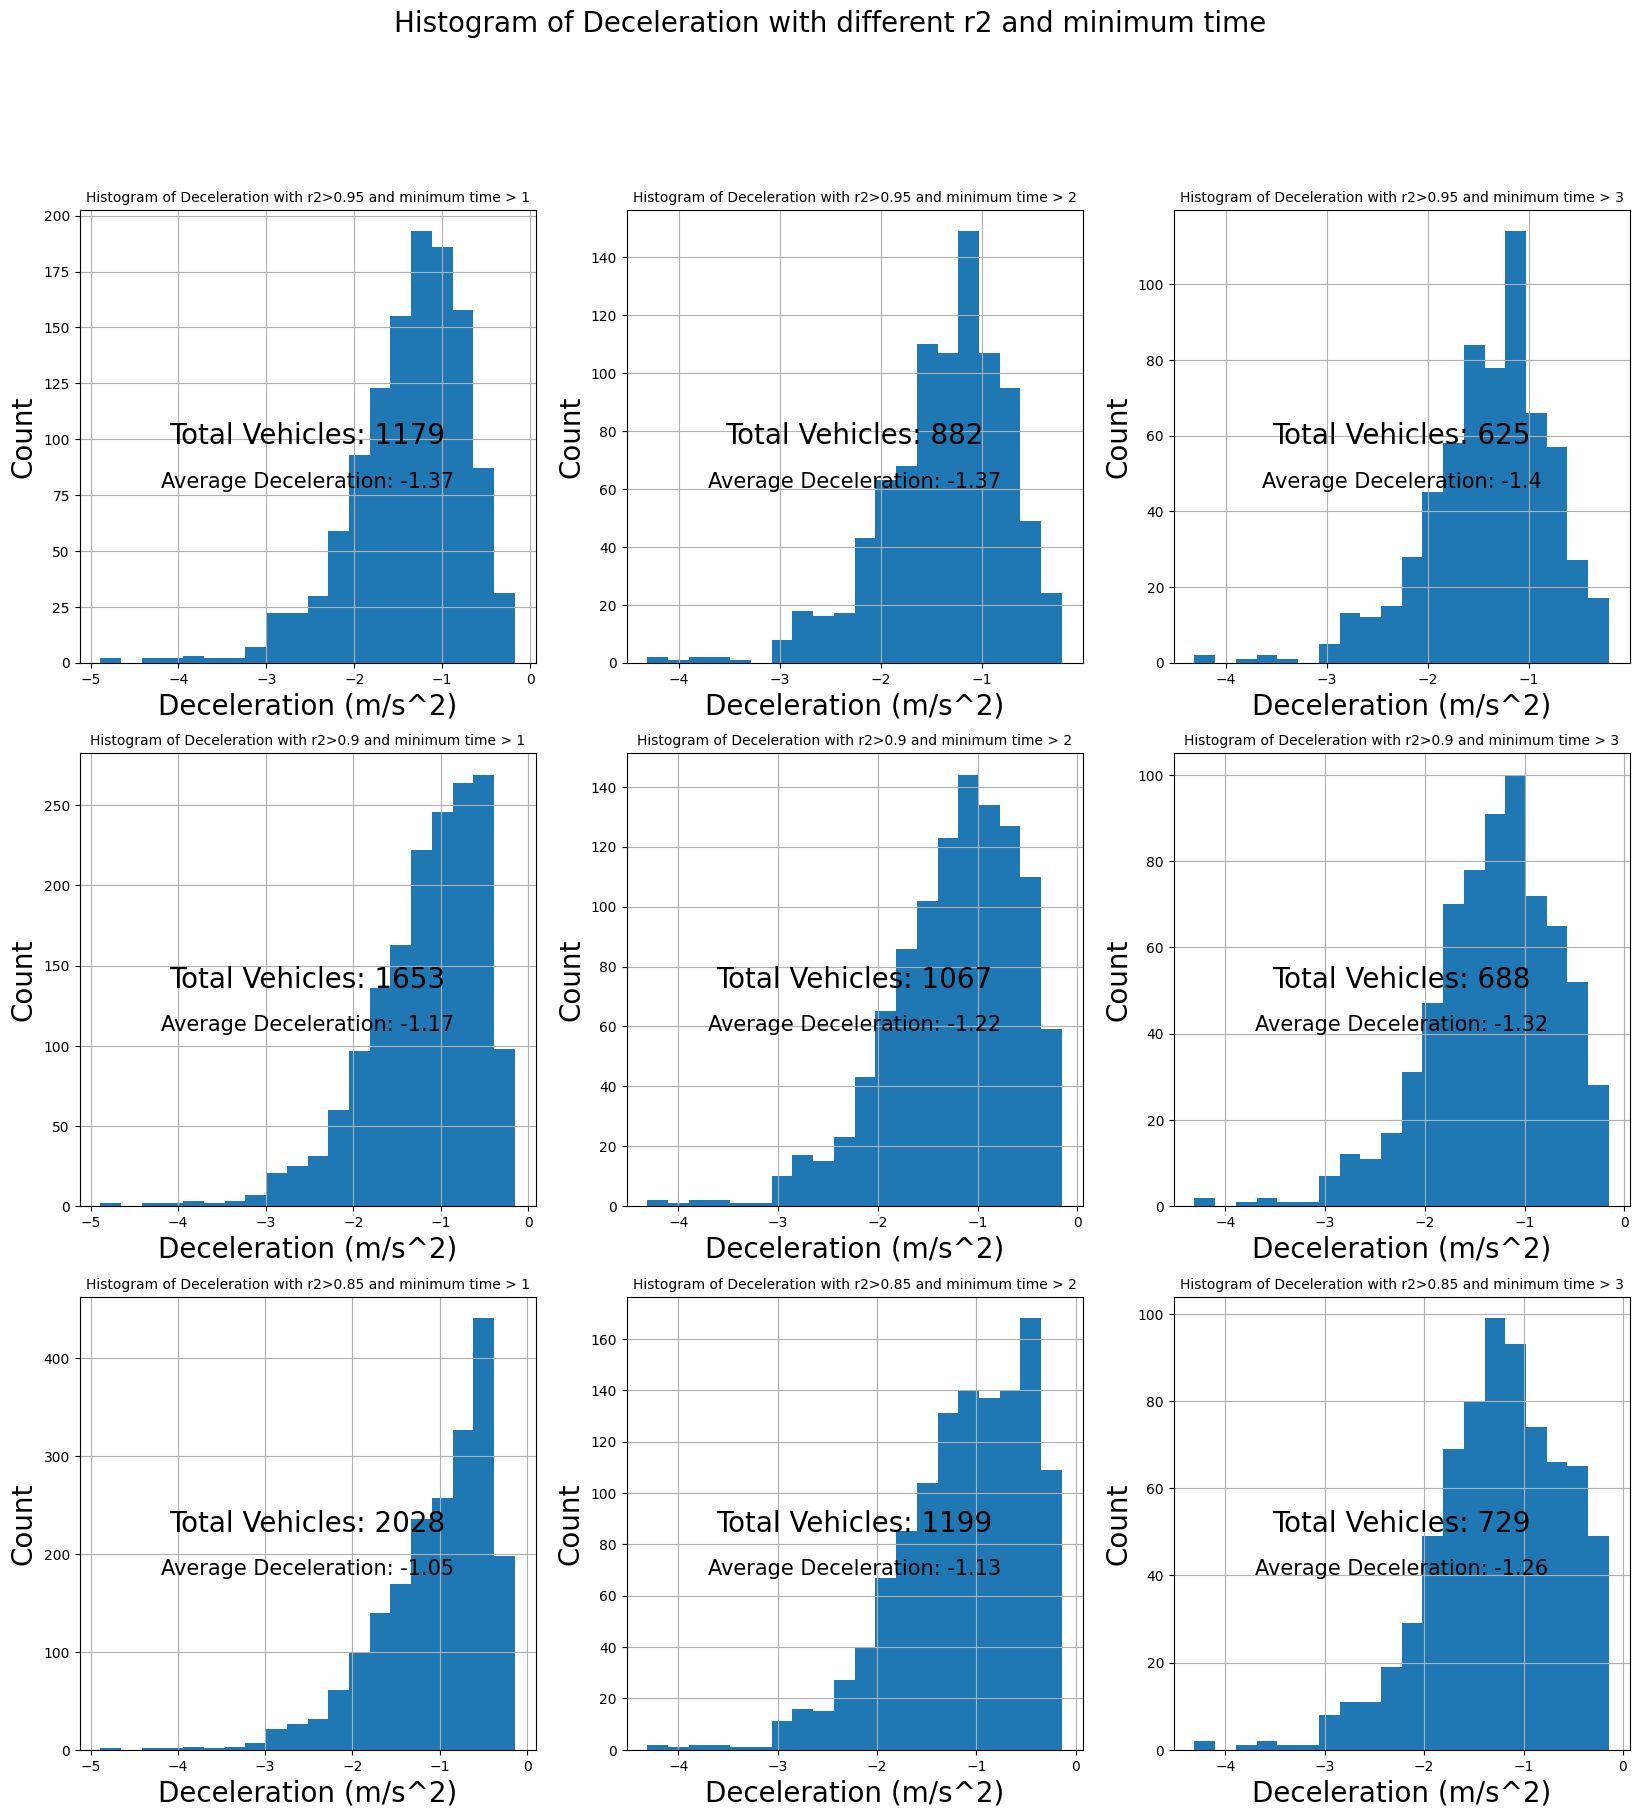

In [ ]:
# #make histogram of decelration 3*3 histogram of decelration with different r2 and minimum time
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle(
    "Histogram of Deceleration with different r2 and minimum time", fontsize=20
)
# r2>0.95 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[0, 0])
axs[0, 0].set_title(
    "Histogram of Deceleration with r2>0.95 and minimum time > 1", fontsize=10
)
axs[0, 0].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[0, 0].set_ylabel("Count", fontsize=20)
axs[0, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[0, 0].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=15,
)

# r2>0.95 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title(
    "Histogram of Deceleration with r2>0.95 and minimum time > 2", fontsize=10
)
axs[0, 1].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[0, 1].set_ylabel("Count", fontsize=20)
axs[0, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[0, 1].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=15,
)

# r2>0.95 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[0, 2])
axs[0, 2].set_title(
    "Histogram of Deceleration with r2>0.95 and minimum time > 3", fontsize=10
)
axs[0, 2].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[0, 2].set_ylabel("Count", fontsize=20)
axs[0, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[0, 2].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=15,
)

# r2>0.9 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.9)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title(
    "Histogram of Deceleration with r2>0.9 and minimum time > 1", fontsize=10
)
axs[1, 0].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[1, 0].set_ylabel("Count", fontsize=20)
axs[1, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[1, 0].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=15,
)

# r2>0.9 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.9)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title(
    "Histogram of Deceleration with r2>0.9 and minimum time > 2", fontsize=10
)
axs[1, 1].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[1, 1].set_ylabel("Count", fontsize=20)
axs[1, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[1, 1].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=15,
)

# r2>0.9 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.9)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[1, 2])
axs[1, 2].set_title(
    "Histogram of Deceleration with r2>0.9 and minimum time > 3", fontsize=10
)
axs[1, 2].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[1, 2].set_ylabel("Count", fontsize=20)
axs[1, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[1, 2].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.9)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=15,
)

# r2>0.85 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title(
    "Histogram of Deceleration with r2>0.85 and minimum time > 1", fontsize=10
)
axs[2, 0].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[2, 0].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=15,
)

# r2>0.85 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title(
    "Histogram of Deceleration with r2>0.85 and minimum time > 2", fontsize=10
)
axs[2, 1].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[2, 1].set_ylabel("Count", fontsize=20)
axs[2, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[2, 1].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=15,
)

# r2>0.85 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("decel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[2, 2])
axs[2, 2].set_title(
    "Histogram of Deceleration with r2>0.85 and minimum time > 3", fontsize=10
)
axs[2, 2].set_xlabel("Deceleration (m/s^2)", fontsize=20)
axs[2, 2].set_ylabel("Count", fontsize=20)
axs[2, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=20,
)
# write average deceleration on the graph with accuracy of actual value
axs[2, 2].text(
    0.5,
    0.4,
    "Average Deceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("decel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=15,
)

plt.show()


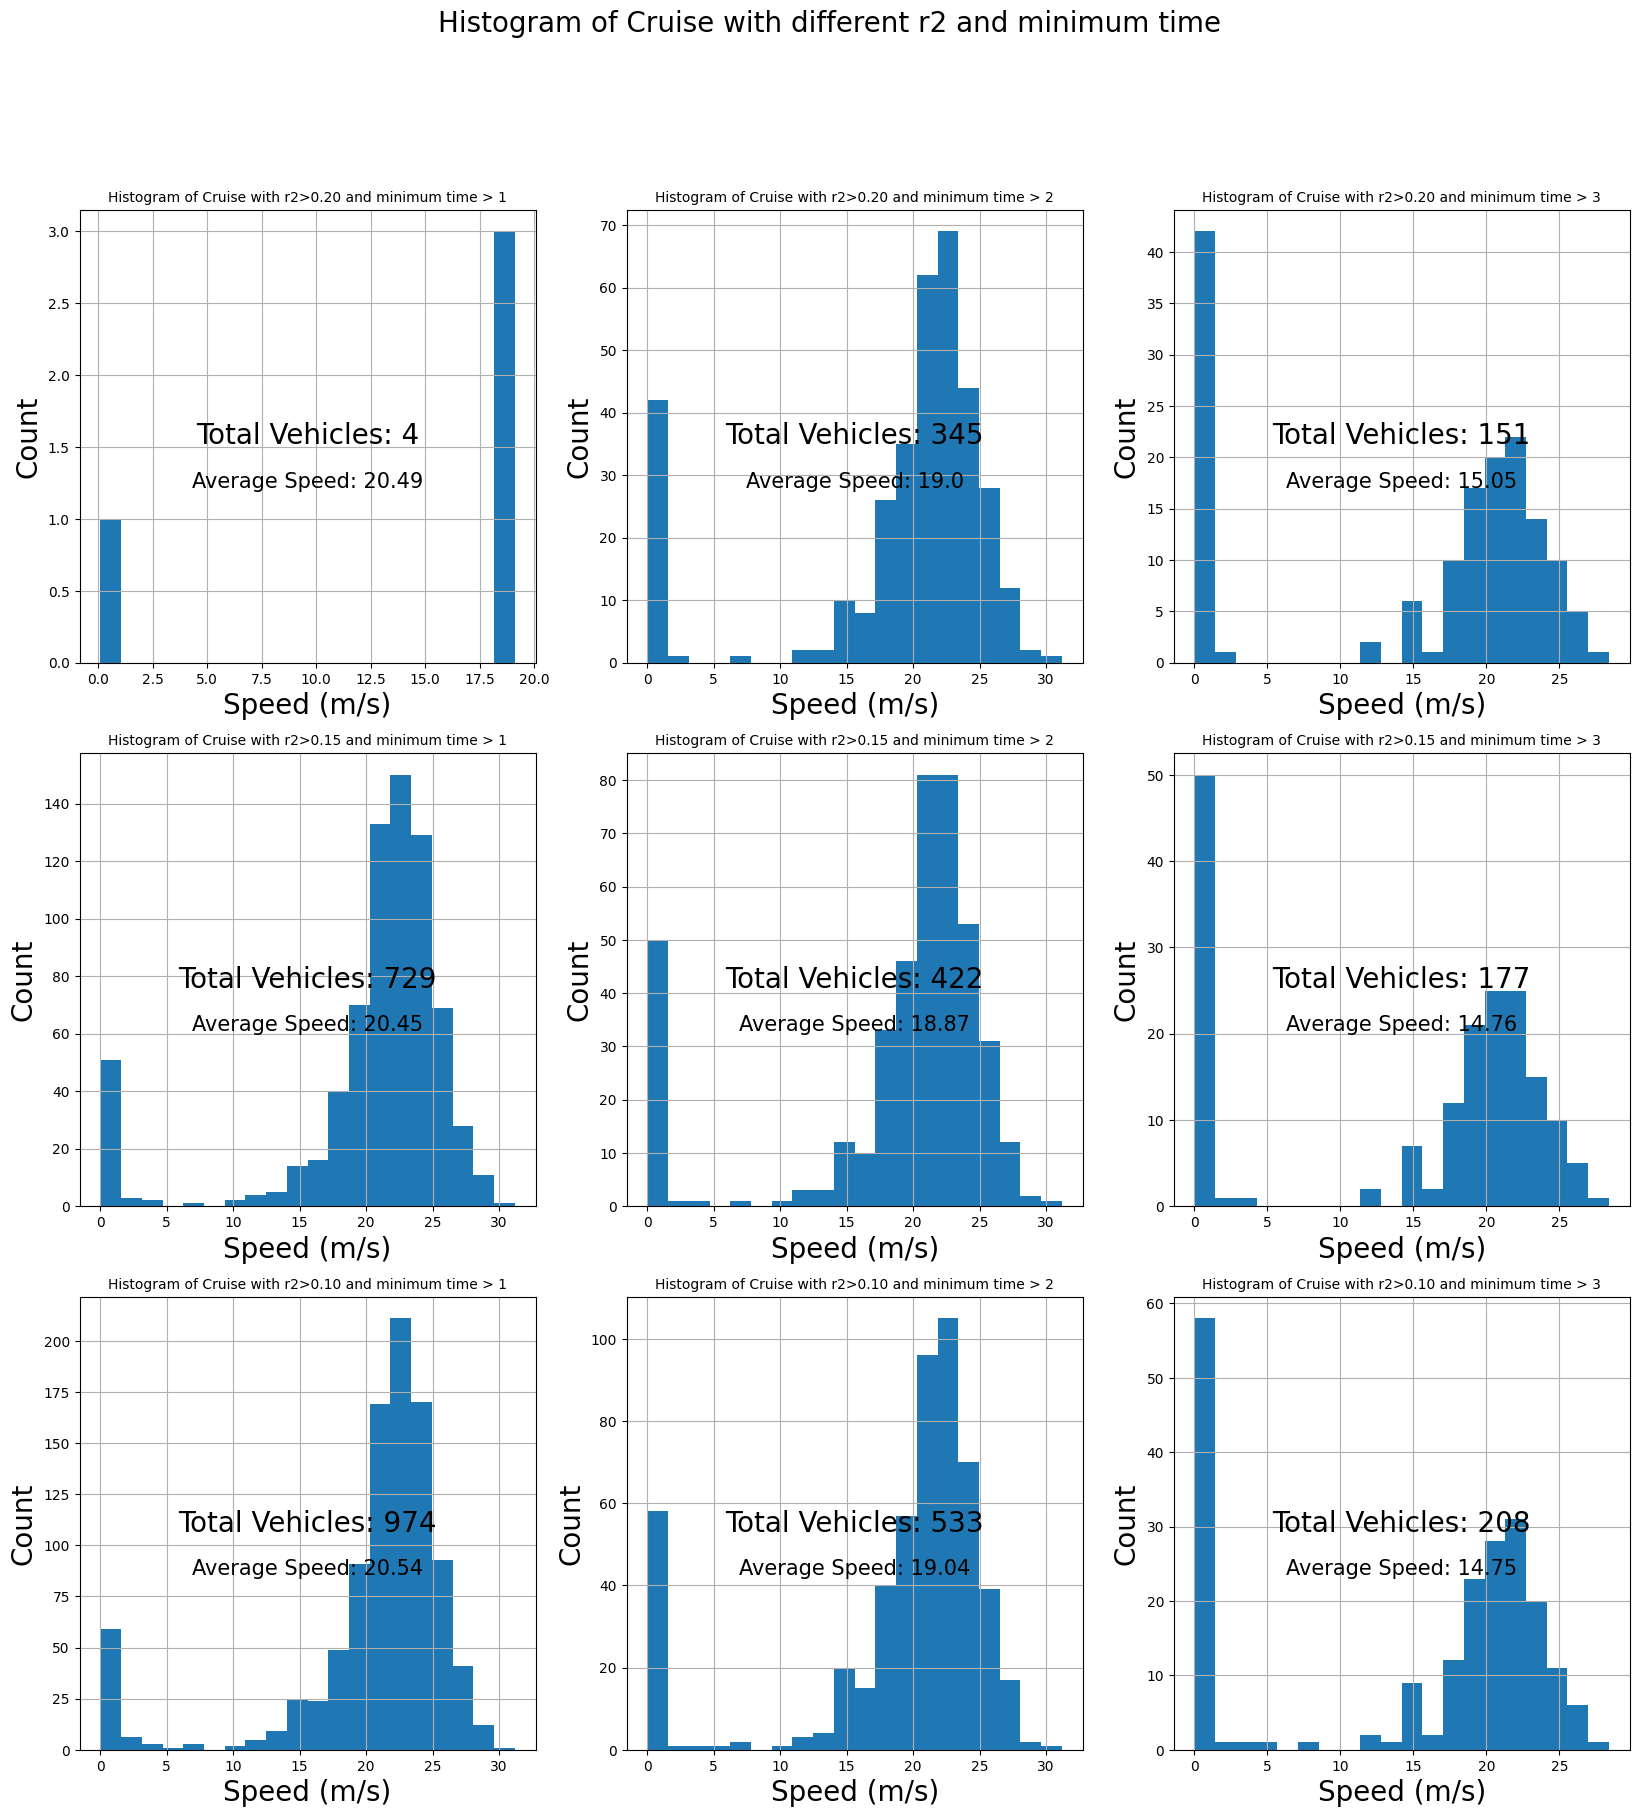

In [ ]:
# histogram of cruise , speed

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle("Histogram of Cruise with different r2 and minimum time", fontsize=20)

# r2>0.20 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.80)
    & (summary_df["minimum_time"] > 1),
    "speed",
].hist(bins=20, ax=axs[0, 0])
axs[0, 0].set_title(
    "Histogram of Cruise with r2>0.20 and minimum time > 1", fontsize=10
)
axs[0, 0].set_xlabel("Speed (m/s)", fontsize=20)
axs[0, 0].set_ylabel("Count", fontsize=20)
axs[0, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.80)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[0, 0].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=15,
)

# r2>0.20 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.20)
    & (summary_df["minimum_time"] > 2),
    "speed",
].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title(
    "Histogram of Cruise with r2>0.20 and minimum time > 2", fontsize=10
)
axs[0, 1].set_xlabel("Speed (m/s)", fontsize=20)
axs[0, 1].set_ylabel("Count", fontsize=20)
axs[0, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[0, 1].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=15,
)

# r2>0.20 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.20)
    & (summary_df["minimum_time"] > 3),
    "speed",
].hist(bins=20, ax=axs[0, 2])
axs[0, 2].set_title(
    "Histogram of Cruise with r2>0.20 and minimum time > 3", fontsize=10
)
axs[0, 2].set_xlabel("Speed (m/s)", fontsize=20)
axs[0, 2].set_ylabel("Count", fontsize=20)
axs[0, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[0, 2].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.20)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=15,
)

# r2>0.15 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.15)
    & (summary_df["minimum_time"] > 1),
    "speed",
].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title(
    "Histogram of Cruise with r2>0.15 and minimum time > 1", fontsize=10
)
axs[1, 0].set_xlabel("Speed (m/s)", fontsize=20)
axs[1, 0].set_ylabel("Count", fontsize=20)
axs[1, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[1, 0].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=15,
)

# r2>0.15 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.15)
    & (summary_df["minimum_time"] > 2),
    "speed",
].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title(
    "Histogram of Cruise with r2>0.15 and minimum time > 2", fontsize=10
)
axs[1, 1].set_xlabel("Speed (m/s)", fontsize=20)
axs[1, 1].set_ylabel("Count", fontsize=20)
axs[1, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[1, 1].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=15,
)

# r2>0.15 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.15)
    & (summary_df["minimum_time"] > 3),
    "speed",
].hist(bins=20, ax=axs[1, 2])
axs[1, 2].set_title(
    "Histogram of Cruise with r2>0.15 and minimum time > 3", fontsize=10
)
axs[1, 2].set_xlabel("Speed (m/s)", fontsize=20)
axs[1, 2].set_ylabel("Count", fontsize=20)
axs[1, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[1, 2].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.15)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=15,
)

# r2>0.10 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.10)
    & (summary_df["minimum_time"] > 1),
    "speed",
].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title(
    "Histogram of Cruise with r2>0.10 and minimum time > 1", fontsize=10
)
axs[2, 0].set_xlabel("Speed (m/s)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[2, 0].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 1),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=15,
)

# r2>0.10 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.10)
    & (summary_df["minimum_time"] > 2),
    "speed",
].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title(
    "Histogram of Cruise with r2>0.10 and minimum time > 2", fontsize=10
)
axs[2, 1].set_xlabel("Speed (m/s)", fontsize=20)
axs[2, 1].set_ylabel("Count", fontsize=20)
axs[2, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[2, 1].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 2),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=15,
)

# r2>0.10 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("cruise"))
    & (summary_df["r2"] > 0.10)
    & (summary_df["minimum_time"] > 3),
    "speed",
].hist(bins=20, ax=axs[2, 2])
axs[2, 2].set_title(
    "Histogram of Cruise with r2>0.10 and minimum time > 3", fontsize=10
)
axs[2, 2].set_xlabel("Speed (m/s)", fontsize=20)
axs[2, 2].set_ylabel("Count", fontsize=20)
axs[2, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=20,
)
# write average speed on the graph with accuracy of actual value
axs[2, 2].text(
    0.5,
    0.4,
    "Average Speed: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("cruise"))
                & (summary_df["r2"] > 0.10)
                & (summary_df["minimum_time"] > 3),
                "speed",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=15,
)

plt.show()


In [ ]:
summary_df


,vehicle_id,mean_time,total_seconds,break,y0,speed,slope,r2,rmse,start,end,type,minimum_time
0,55583,2022-05-23 17:15:55.730996224,20.017547,0,20.490932,19.864164,-0.522752,0.873620,0.143611,0.000000,2.426438,decel,2.426438
1,55583,2022-05-23 17:15:55.730996224,20.017547,1,23.362322,11.487335,-1.706129,0.997292,0.231498,2.426438,11.532395,decel,9.105957
2,55583,2022-05-23 17:15:55.730996224,20.017547,2,18.853666,1.893999,-1.315174,0.797753,0.537512,11.532395,14.347191,undefined,2.814796
3,55583,2022-05-23 17:15:55.730996224,20.017547,3,-0.250681,0.008900,0.016400,0.178153,0.031112,14.347191,17.355141,cruise,3.007950
4,55583,2022-05-23 17:15:55.730996224,20.017547,4,-13.615925,1.061903,0.786503,0.932066,0.160893,17.355141,20.017547,accel,2.662406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18892,78161,2022-05-24 09:30:17.494800128,11.662750,0,15.653292,15.556947,-0.093605,0.228735,0.107360,0.000000,2.108962,cruise,2.108962
18893,78161,2022-05-24 09:30:17.494800128,11.662750,1,19.879557,14.982613,-2.097559,0.960127,0.048329,2.108962,2.609019,decel,0.500057
18894,78161,2022-05-24 09:30:17.494800128,11.662750,2,12.929087,14.776984,0.566457,0.766748,0.129283,2.609019,3.980914,accel,1.371895
18895,78161,2022-05-24 09:30:17.494800128,11.662750,3,19.471200,11.607118,-1.076913,0.988768,0.220554,3.980914,10.631969,decel,6.651055


In [ ]:
from tabulate import tabulate


SyntaxError: invalid syntax (3456665968.py, line 3)

In [ ]:
veh_df


,epoch_time,iSYS5220_TrackClass,ui32_objectID,ui16_ageCount,ui16_predictionCount,ui16_staticCount,f32_trackQuality,si16_motion_eventZoneIndex,si16_presence_eventZoneIndex,f32_positionX_m,...,f32_distanceToFront_m,f32_distanceToBack_m,f32_length_m,f32_width_m,lat,lon,dt,box,cum_distance,total_seconds
0,1.653344e+09,30,55583,62,0,3200,71.553864,-2,-2,-113.269920,...,-0.402507,-1.815666,1.413159,2.5,33.234408,-87.616867,2022-05-23 17:15:45.722148,East thru,0.000000,0.000000
1,1.653344e+09,30,55583,65,0,3200,69.417610,-2,-2,-111.006996,...,-0.359966,-2.530175,2.170209,2.5,33.234399,-87.616896,2022-05-23 17:15:45.831473,East thru,2.884974,0.109325
2,1.653344e+09,30,55583,67,0,3200,70.369827,-2,-2,-109.481071,...,-0.337895,-2.602272,2.269787,2.5,33.234392,-87.616916,2022-05-23 17:15:45.941743,East thru,4.803031,0.219595
3,1.653344e+09,30,55583,69,0,3200,69.391907,-2,-2,-107.564842,...,-0.380242,-2.636881,2.269787,2.5,33.234383,-87.616937,2022-05-23 17:15:46.049568,East thru,7.082945,0.327420
4,1.653344e+09,30,55583,71,0,3200,70.101532,-2,-2,-105.924232,...,-0.471238,-2.639173,2.269787,2.5,33.234377,-87.616959,2022-05-23 17:15:46.158243,East thru,9.212743,0.436095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301398,1.653403e+09,30,78161,283,0,3200,82.933067,-2,2,-15.797193,...,2.595815,-2.716115,5.589902,2.5,33.234077,-87.618237,2022-05-24 09:30:22.895537,East thru,135.079543,11.229622
301399,1.653403e+09,30,78161,285,0,3200,81.740471,-2,2,-15.253442,...,2.525057,-2.667043,5.589902,2.5,33.234076,-87.618248,2022-05-24 09:30:23.003535,East thru,136.089327,11.337620
301400,1.653403e+09,30,78161,287,0,3200,81.326630,-2,2,-14.234218,...,2.497697,-2.357256,5.589902,2.5,33.234072,-87.618261,2022-05-24 09:30:23.111436,East thru,137.395745,11.445521
301401,1.653403e+09,30,78161,289,0,3200,82.397690,-2,2,-13.322368,...,2.356713,-2.135158,5.589902,2.5,33.234069,-87.618274,2022-05-24 09:30:23.220487,East thru,138.596736,11.554572


In [ ]:
# # for loop to plot  5 vehicles with the results
# for i in range(1):
#     # get the vehicle id
#     vehicle_id = results[i]['vehicle_id']

#     # get the vehicle data
#     vehicle_data = veh_df[veh_df['ui32_objectID'] == vehicle_id]

#     # create the figure
#     fig = px.line(vehicle_data, x="total_seconds", y="f32_velocityInDir_mps")

#     # loop through the line fits
#     for line_fit in results[i]['line_fits']:
#         # get the break
#         b0 = breaks[line_fit['break']]
#         b1 = breaks[line_fit['break'] + 1]

#         # get the xHat
#         slicer = (vehicle_data["total_seconds"] >= b0) & (vehicle_data["total_seconds"] < b1)
#         xHat = vehicle_data["total_seconds"][slicer]

#         # get the yHat
#         #yHat = my_pwlf.predict(xHat)
#         #yHat = vehicle_data["f32_velocityInDir_mps"][slicer]
#         yHat = my_pwlf.predict(xHat.values)
#         # add the line
#         fig.add_scatter(x=xHat, y=yHat, mode="lines")
#         #fig add vehicle id on title
#         fig.update_layout(title=f"Vehicle ID: {vehicle_id}")


#         # add the text
#         fig.add_annotation(
#             x=np.mean(xHat),
#             y=np.mean(yHat),
#             text=f"accel: {line_fit['slope']:.2f} m/s^2<br>r^2: {line_fit['r2']:.2f}<br>type: {line_fit['type']}<br>speed: {line_fit['mean_speed']:.2f} mps",
#             showarrow=False,
#             font=dict(size=14),
#         )

#     # show the figure
#     fig.show()


In [ ]:
# from sklearn.metrics import r2_score
# import plotly.express as px
# import pandas as pd
# import numpy as np
# import pwlf
# import datetime
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# import plotly.express as px
# from fpdf import FPDF
# from matplotlib.backends.backend_pdf import PdfPages
# import os
# import plotly.io as pio
# import kaleido as kaleido


# dff = pd.read_csv('veh_df.csv')


# dff_gro = dff.groupby('ui32_objectID')
# for name, group in dff_gro:
#     group =  pd.DataFrame(group, columns= ['ui16_predictionCount','f32_positionX_m','f32_positionY_m','f32_velocityInDir_mps','lat','lon','dt'])

#     group["dt"] = pd.to_datetime(group["dt"])
#     # create a new column with total seconds
#     group["total_seconds"] = (group["dt"] - group["dt"].min()).dt.total_seconds()
#     group.set_index("dt", inplace=True)
#     group.head()

#     #assign pwlf model to variable
#     my_pwlf = pwlf.PiecewiseLinFit(group["total_seconds"], group["f32_velocityInDir_mps"])
#     #fit the model
#     breaks = my_pwlf.fit(5)
#     print(breaks)
#     #predict the model


#     fig = px.line(group, x="total_seconds", y="f32_velocityInDir_mps" )
# #add car id to title
#     fig.update_layout(title=f"Car {name}", xaxis_title="Time (seconds)", yaxis_title="Velocity (m/s)")

#     xHat = np.linspace(group["total_seconds"].min(), group["total_seconds"].max(), 100)
#     yHat = my_pwlf.predict(xHat)  # predict the y values

#     #fig.add_scatter(x=xHat, y=yHat, mode="lines")


#     #assign the thresholds
#     cruise_thresh=0.1
#     cruse_rmse_thresh=0.25
#     accel_rmse_thresh=0.25
#     decel_rmse_thresh=0.25
#     stopped_rmse_thresh=0
#     seconds = 3
#     i = 0
#     slopes = my_pwlf.calc_slopes()

#     #show fig pwlf with car id
#     r2 = r2_score(yHat, yHat)
#     #rmse = np.sqrt(mean_squared_error(yHat, yHat))


#     # loop through the slopes
#     for i, (b0, b1 )in enumerate(zip(breaks[:-1], breaks[1:], )):
#     #for i in range(len(slopes)):
#         # get the x values for the line


#         slicer = (group["total_seconds"] >= breaks[i]) & (group["total_seconds"] < breaks[i + 1])
#         xHat = group["total_seconds"][slicer]

#         #xHat = np.linspace(group["total_seconds"].min(), group["total_seconds"].max(), 100)
#         # get the y values for the line

#         yHat = my_pwlf.predict(xHat)

#         # get the slope
#         slope = slopes[i]
#         #get speed
#         speed = np.mean(yHat)
#         # get the r2 score for the line
#         #r2 = r2_score(yHat, yHat)

#         #fix r2 error


#         #rmse = np.sqrt(mean_squared_error(yHat, yHat))
#         #fix rmse error
#         rmse = np.sqrt(np.mean((yHat - yHat)**2))

#         # get the number of points
#         print("slope: %.2f, rmse: %.2f, r2: %.2f" % (slope, rmse, r2))


#         # if statment with thrusholds to find accel, decel, cruise , stopped:
#         if abs(slope) < cruise_thresh and rmse < cruse_rmse_thresh:
#             #assign type to cruise
#             type = "cruise"
#             cruise_speed = np.mean(yHat)
#             print('Cruise speed: %.2f' % cruise_speed)
#         elif slope > 0 and rmse < accel_rmse_thresh:
#             #assign type to accel
#             type = "accel"
#             accel_speed = slope
#             print('Accel speed: %.2f' % accel_speed)
#         elif slope < 0 and rmse < decel_rmse_thresh:
#             #assign type to decel
#             type = "decel"
#             decel_speed = slope
#             print('Decel speed: %.2f' % decel_speed)
#         elif slope == 0 and rmse < stopped_rmse_thresh:
#             #assign type to stopped
#             type = "stopped"
#             stopped_speed = slope
#             print('Stopped speed: %.2f' % stopped_speed)
#         else:
#             type = "Undefined"
#             print("Undefined")

#         #r2 score for each line
#         #r2 = r2_score(group["f32_velocityInDir_mps"][slicer], yHat)
#         #r2 score equation

#         r2 = 1 - (np.sum((yHat - group["f32_velocityInDir_mps"][slicer])**2) / np.sum((group["f32_velocityInDir_mps"][slicer] - np.mean(group["f32_velocityInDir_mps"][slicer]))**2))


#         fig.add_scatter(x=xHat, y=yHat, mode="lines")
#         fig.add_annotation(
#         x=np.mean(xHat),
#         y=np.mean(yHat),
#         text=f"accel: {slopes[i]:.2f} m/s^2<br>r^2: {r2:.2f}<br>type: {type}<br>speed: {speed:.2f} mps",
#         showarrow=False,
#         # make the text bigger
#         font=dict(size=14),
#     )

#         # add text of the slope to the middle of the line
#         #fig. add_annotation( x=np.mean(xHat),y=np.mean(yHat),text=f"accel: {slope:.2f} m/s^2<br>r^2: {r2:.2f}<br>type: {type}<br>speed: {speed:.2f} mps",showarrow=False,font=dict(size=14))

#         #create pdf file for all cars as pdf
#         #plt savefig all_cars.pdf


#     fig.show(renderer="notebook_connected")
#     #fig.write_html(f"car_{name}.html")

#     all_cars = fig.to_html(full_html=False, include_plotlyjs="cdn")
#     with open("all_cars.html", "a") as f:
#         f.write(all_cars)

#     #create pdf file for all cars as pdf
#     #plt savefig all_cars.pdf


#     # Save as pdf
